# Conspiracy Theory Election Notebook




Exploration of Election Twitter dataset

## Importing Data

In [1]:
import pandas as pd
import numpy as np
import json
import jsonlines
import os
from os import path
from PIL import Image
from tqdm.auto import tqdm as tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import listdir
from os.path import isfile, join
from collections import Counter
from nltk import ngrams
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
import warnings
import time
import botometer
warnings.filterwarnings("ignore")

### Sampling to reduce dataset size

Not required if using preprocessed data

In [2]:
homepath = '../../'
election_path = homepath + 'election_data/'

In [3]:
# Files downloaded from Emily's dataset
months = ['2020-06/','2020-07/','2020-08/','2020-09/']

In [4]:
# List the csv files in the directories
csv_files = []
filepath = election_path + 'election_csvs/'
files = []
files = [f for f in os.listdir(filepath) if not f.startswith('.')]
for month in months:
    csv_files  += [filepath+month + f for f in listdir(filepath+month) if isfile(join(filepath+month, f)) and not f.startswith('.') and f[-3:] == 'csv']
csv_files = sorted(csv_files)
len(csv_files)

1886

In [9]:
# Timestamps of the csvs
csv_timestamps  = []
for i in range(len(csv_files)):
    csv_timestamps.append(pd.Timestamp(csv_files[i][-23:-18]+csv_files[i][-12:-4]))

In [10]:
# Sampling 

dates = []
hours = []
sample_every = 1

print('No. files:', len(csv_timestamps[::sample_every]))
sample_files =  csv_files[::sample_every]

for i in range(len(csv_timestamps[::sample_every])):
    dates.append(csv_timestamps[::sample_every][i].day)
    hours.append(csv_timestamps[::sample_every][i].hour)

No. files: 1886


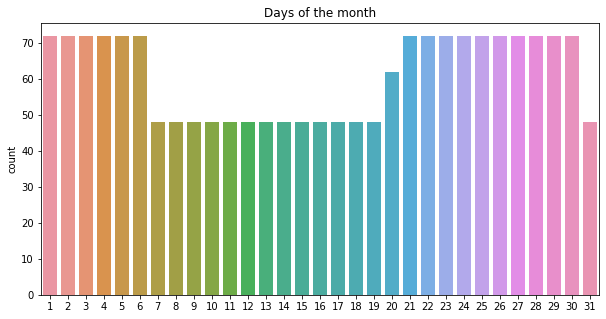

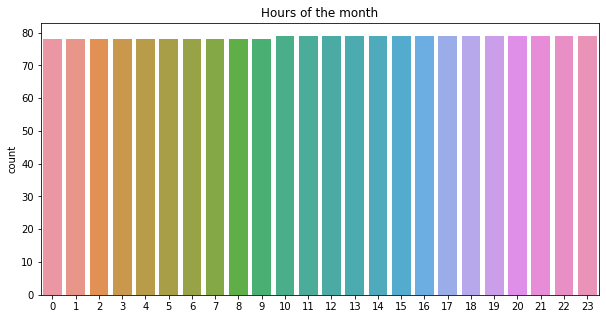

In [11]:
# Make sure the samples have an even number of days in the month and the hours
plt.figure(figsize = (10,5))
plt.title('Days of the month')
sns.countplot(dates)
plt.show()

plt.figure(figsize = (10,5))
plt.title('Hours of the month')
sns.countplot(hours)
plt.show()

In [15]:
# # Get sampled dfs for general corona tweets
control_df = pd.DataFrame()

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_hashtag','rt_rt_count',
            'rt_fav_count','rt_tweetid','rt_urls_list','urls_list','qtd_hashtag',
            'qtd_urls_list','account_creation_date','sent_vader']

for i,file in tqdm(enumerate(sample_files)):
#     control_df = control_df.append(pd.read_csv(file,usecols=col_list))
    control_df = control_df.append(pd.read_csv(file))
    break
control_df.shape

(36067, 63)

In [14]:
for i in control_df.columns:
    print(i)

tweetid
userid
screen_name
date
lang
location
place_id
place_url
place_type
place_name
place_full_name
place_country_code
place_country
place_bounding_box
text
extended
coord
reply_userid
reply_screen
reply_statusid
tweet_type
friends_count
listed_count
followers_count
favourites_count
statuses_count
verified
hashtag
urls_list
profile_pic_url
profile_banner_url
display_name
date_first_tweet
account_creation_date
rt_urls_list
mentionid
mentionsn
rt_screen
rt_userid
rt_text
rt_hashtag
rt_qtd_count
rt_rt_count
rt_reply_count
rt_fav_count
rt_tweetid
rt_location
qtd_screen
qtd_userid
qtd_text
qtd_hashtag
qtd_qtd_count
qtd_rt_count
qtd_reply_count
qtd_fav_count
qtd_tweetid
qtd_urls_list
qtd_location
sent_vader
token
media_urls
rt_media_urls
q_media_urls


In [145]:
# Get random names from control df

# import random
# len(control_df.screen_name.unique())
# rands = random.choices(control_df.screen_name.unique(), k= 5000)
# rands = [i.lower() for i in rands]
# control_names = pd.DataFrame(rands, columns=['names'])
# control_names.to_csv('Botometer_to_query/control_election_names.csv',index=False)

# Conspiracy theory analysis

In [381]:
def create_cloud(string,exclude = None):
    wordcloud = WordCloud(width=400,height=400,max_font_size=20, max_words=20,
                      collocations=False, background_color="white"
                          #, stopwords = exclude
                     ).generate(string)

    # Display the generated image:
    plt.figure(figsize = (5,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [58]:
# Find hashtags for tweets
def hash_tweets_orig(string,df):
    tweets = df[df.hashtag.str.contains("'"+string+"'")]
    return tweets

def hash_tweets_qtd(string,df):
    tweets = df[df.rt_hashtag.str.contains("'"+string+"'")]
    return tweets

def hash_tweets_rt(string,df):
    tweets = df[df.rt_hashtag.str.contains("'"+string+"'")]
    return tweets

In [13]:
# Find text for tweets
def text_tweets(string,df):
    tweets = df[df.text.str.contains(string)]
    return tweets

In [14]:
# Find urls for tweets
def url_tweets(string,df):
    tweets = df[df.urls_list.str.contains(string)]
    return tweets

In [57]:
# Get tweets, create a cloud, get users associated with each url substring
def get_hashtags_orig(df,hashtag_list,cloud=True,printing=False):
    users = set()
    hash_dict, tweet_dict = {}, {}
    hash_df = pd.DataFrame()

    for hashtag in hashtag_list:
        these_hashtags = hash_tweets_orig(hashtag,df)
        hash_df = hash_df.append(these_hashtags)
        hash_dict[hashtag] = these_hashtags.screen_name.unique()
        tweet_dict[hashtag] = these_hashtags
        these_users = list(these_hashtags.screen_name.unique())
        users.update(these_users)
        if cloud:
            related_hashs = ' '.join(these_hashtags.hashtag)
            try:
                create_cloud(related_hashs,exclude = [hashtag])
            except:
                pass
        if printing:
            print('\n%s num tweets: %d' % (hashtag, len(these_hashtags)))
            print('%s unique users: %d' %(hashtag, len(these_users)))
    
    return list(users), hash_dict, hash_df, tweet_dict



# Get tweets, create a cloud, get users associated with each url substring
def get_hashtags_qtd(df,hashtag_list,cloud=True,printing=False):
    users = set()
    hash_dict, tweet_dict = {}, {}
    hash_df = pd.DataFrame()

    for hashtag in hashtag_list:
        these_hashtags = hash_tweets_qtd(hashtag,df)
        hash_df = hash_df.append(these_hashtags)
        hash_dict[hashtag] = these_hashtags.screen_name.unique()
        tweet_dict[hashtag] = these_hashtags
        these_users = list(these_hashtags.screen_name.unique())
        users.update(these_users)
        if cloud:
            related_hashs = ' '.join(these_hashtags.qtd_hashtag)
            try:
                create_cloud(related_hashs,exclude = [hashtag])
            except:
                pass
        if printing:
            print('\n%s num tweets: %d' % (hashtag, len(these_hashtags)))
            print('%s unique users: %d' %(hashtag, len(these_users)))
    
    return list(users), hash_dict, hash_df, tweet_dict



# Get tweets, create a cloud, get users associated with each url substring
def get_hashtags_rt(df,hashtag_list,cloud=True,printing=False):
    users = set()
    hash_dict, tweet_dict = {}, {}
    hash_df = pd.DataFrame()

    for hashtag in hashtag_list:
        these_hashtags = hash_tweets_rt(hashtag,df)
        hash_df = hash_df.append(these_hashtags)
        hash_dict[hashtag] = these_hashtags.screen_name.unique()
        tweet_dict[hashtag] = these_hashtags
        these_users = list(these_hashtags.screen_name.unique())
        users.update(these_users)
        if cloud:
            related_hashs = ' '.join(these_hashtags.rt_hashtag)
            try:
                create_cloud(related_hashs,exclude = [hashtag])
            except:
                pass
        if printing:
            print('\n%s num tweets: %d' % (hashtag, len(these_hashtags)))
            print('%s unique users: %d' %(hashtag, len(these_users)))
    
    return list(users), hash_dict, hash_df, tweet_dict

In [16]:
# Get tweets, create a cloud, get users associated with each url substring
def get_url_usertweets(df,url_list):
    users = set()
    url_dict = {}
    url_df = pd.DataFrame()

    for url in url_list:
        these_urls = url_tweets(url,df)
        url_df = url_df.append(these_urls)
        url_dict[url] = these_urls.screen_name.unique()
        users.update(list(these_urls.screen_name.unique()))
    
    return list(users), url_dict, url_df

In [17]:
# Get tweets, create a cloud, get users associated with each url substring
def get_text_tweets(df,text_list):
    users = []
    text_dict = {}
    text_df = pd.DataFrame()

    for text in text_list:
        these_keyword = text_tweets(text,df)
        text_df = text_df.append(these_keyword)
        text_dict[text] = these_keyword.screen_name.unique()
        users += list(these_keyword.screen_name.unique())
    
    return users, text_dict, text_df

In [18]:
def unique(list1): 
    x = np.array(list1) 
    return np.unique(x)

In [19]:
""" 
Tweet Columns
       'tweetid', 'userid', 'screen_name', 'date', 'lang', 'location',
       'place_id', 'place_url', 'place_type', 'place_name', 'place_full_name',
       'place_country_code', 'place_country', 'place_bounding_box', 'text',
       'extended', 'coord', 'reply_userid', 'reply_screen', 'reply_statusid',
       'tweet_type', 'friends_count', 'listed_count', 'followers_count',
       'favourites_count', 'statuses_count', 'verified', 'hashtag',
       'urls_list', 'profile_pic_url', 'profile_banner_url', 'display_name',
       'date_first_tweet', 'account_creation_date', 'rt_urls_list',
       'mentionid', 'mentionsn', 'rt_screen', 'rt_userid', 'rt_text',
       'rt_hashtag', 'rt_qtd_count', 'rt_rt_count', 'rt_reply_count',
       'rt_fav_count', 'rt_tweetid', 'qtd_screen', 'qtd_userid', 'qtd_text',
       'qtd_hashtag', 'qtd_qtd_count', 'qtd_rt_count', 'qtd_reply_count',
       'qtd_fav_count', 'qtd_tweetid', 'qtd_urls_list'                         
"""

# rt_screen is who is being retweeted

" \nTweet Columns\n       'tweetid', 'userid', 'screen_name', 'date', 'lang', 'location',\n       'place_id', 'place_url', 'place_type', 'place_name', 'place_full_name',\n       'place_country_code', 'place_country', 'place_bounding_box', 'text',\n       'extended', 'coord', 'reply_userid', 'reply_screen', 'reply_statusid',\n       'tweet_type', 'friends_count', 'listed_count', 'followers_count',\n       'favourites_count', 'statuses_count', 'verified', 'hashtag',\n       'urls_list', 'profile_pic_url', 'profile_banner_url', 'display_name',\n       'date_first_tweet', 'account_creation_date', 'rt_urls_list',\n       'mentionid', 'mentionsn', 'rt_screen', 'rt_userid', 'rt_text',\n       'rt_hashtag', 'rt_qtd_count', 'rt_rt_count', 'rt_reply_count',\n       'rt_fav_count', 'rt_tweetid', 'qtd_screen', 'qtd_userid', 'qtd_text',\n       'qtd_hashtag', 'qtd_qtd_count', 'qtd_rt_count', 'qtd_reply_count',\n       'qtd_fav_count', 'qtd_tweetid', 'qtd_urls_list'                         \n"

In [53]:
# Conspiracy theory hashtags
qanon_keywords = ['qanon',
# qanon_keywords = [
                  'wwg1wga',
                  'greatawakening',
                  'taketheoath',
                  'digitalsoldier',
                  'qarmy',
                  'deepstate'
                 ] 

conspiracy_keywords = []
# conspiracy_keywords = ['conspiracy',
#                        'falseflag',
#                        'deepstate']

gate_keywords = ['pizzagate',
                 'obamagate',
                 'pedogate',
                 'bountygate'
                 ]

all_keywords = qanon_keywords+conspiracy_keywords+gate_keywords

In [54]:
# News url substrings to look for in tweet url lists (Try sampling)

news_sources = ['msnbc',
                'nydailynews',
                'reuters',
                'foxnews',
                'cnn',
                'wsj',
                'huffpost',
                'nyt',
                'dailymail',
                'washingtonpost',
                'theguardian',
                'abcnews',
                'bbc',
                'usatoday',
                'infowars',
                'oann',
                'latimes',
                'cnbc',
                'boston',
                'yahoo',
                'chicagotribune',
                'msn',
                'breitbart'
               ]

### Get tweets from preprocessed csvs

Used once the conspiracy theory tweets have been found and saved

In [232]:
# bounty_df = pd.DataFrame()
# for i in range(1,4):
#     bounty_df = bounty_df.append(pd.read_csv(election_path + 'election_just_consp_bountygate_'+str(i)+'.csv'))
# bounty_df.shape

In [233]:
# df.drop_duplicates(inplace = True)
# df.to_csv(election_path + 'election_conspiracies_and_urls.csv', index=False)

In [331]:
# Read all data
# read_df = pd.read_csv(election_path + 'election_conspiracies_and_urls.csv')
# read_df = pd.read_csv(election_path +'election_just_consp_hashtags.csv')
read_df = pd.read_csv(election_path +'election_consp_and_news_urls_2.csv')

In [332]:
read_df.shape

(2558437, 22)

In [272]:
# # Separate retweets from non retweets tweets
# orig_df = df[pd.isnull(df['rt_userid'])]
# rt_df = df.dropna(subset=['rt_userid'])

In [374]:
# Use if all df loaded from csv
tweet_df = read_df.dropna(subset=['hashtag'])
df = pd.DataFrame()

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_rt_count','rt_fav_count',
            'rt_tweetid','urls_list','account_creation_date','sent_vader']

clouds = False

qanon_users=set()
conspiracy_users=set()
gate_users=set()

url_dict = {}

tweet_df.reset_index(drop=True,inplace=True)
tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
tweet_df.sent_vader = tweet_df.sent_vader.astype(float)
# tweet_df.replace('nan',np.nan,inplace=True)
# tweet_df.hashtag = tweet_df.hashtag.str.replace("'", '')

qanon_users_h, qanon_dict_h, qanon_df_h, qanon_dict_df_h = get_hashtags_tweets(tweet_df,qanon_keywords,cloud=clouds,printing=True)
conspiracy_users_h, conspiracy_dict_h, conspiracy_df_h, conspiracy_dict_df_h = get_hashtags_tweets(tweet_df,conspiracy_keywords,cloud=clouds,printing=True)
gate_users_h, gate_dict_h, gate_df_h, gate_dict_df_h = get_hashtags_tweets(tweet_df,gate_keywords,cloud=clouds,printing=True)

tweet_df = tweet_df[tweet_df.urls_list!='[]']

qanon_users.update(qanon_users_h)
conspiracy_users.update(conspiracy_users_h)
gate_users.update(gate_users_h)

# Get tweets, create a cloud, get users associated with each news source
url_users, url_dict_temp, news_url_df = get_url_usertweets(tweet_df,news_sources)
for urlkey,urlval in url_dict_temp.items():
    this_set = set(urlval)
    if url_dict.get(urlkey):
        this_set.update(url_dict.get(urlkey))
    url_dict[urlkey]=this_set

df = df.append(qanon_df_h)
df = df.append(conspiracy_df_h)
df = df.append(gate_df_h)

df = df.append(news_url_df)

del tweet_df, news_url_df
gc.collect()


qanon num tweets: 239177
qanon unique users: 74217

wwg1wga num tweets: 359320
wwg1wga unique users: 85334

greatawakening num tweets: 83561
greatawakening unique users: 31170

taketheoath num tweets: 129529
taketheoath unique users: 31644

digitalsoldier num tweets: 59914
digitalsoldier unique users: 23395

qarmy num tweets: 57582
qarmy unique users: 17738

deepstate num tweets: 48625
deepstate unique users: 24110

pizzagate num tweets: 23567
pizzagate unique users: 12454

obamagate num tweets: 241888
obamagate unique users: 84143

pedogate num tweets: 10827
pedogate unique users: 6674

bountygate num tweets: 223568
bountygate unique users: 98115


2417

In [375]:
# Get dictionary with key as consp # and value the users and tweet_df
all_dict = {}
all_dict.update(qanon_dict_h)
all_dict.update(conspiracy_dict_h)
all_dict.update(gate_dict_h)

all_dict_df = {}
all_dict_df.update(qanon_dict_df_h)
all_dict_df.update(conspiracy_dict_df_h)
all_dict_df.update(gate_dict_df_h)

In [376]:
idx = ['#' + i if i != 'greatawakening' else '#the'+i for i in qanon_keywords + conspiracy_keywords + gate_keywords]
columns = ['Tweets','Unique users','Mean sentiment']
consp_stats = pd.DataFrame(index=idx, columns = columns)

In [377]:
for k, v in all_dict_df.items():
    if k == 'greatawakening':
        k = 'the'+k
    consp_stats.at['#'+k,'Tweets'] = len(v)
    consp_stats.at['#'+k,'Mean sentiment'] = v.sent_vader.mean()
    
        
for k, v in  all_dict.items():
    if k == 'greatawakening':
        k = 'the'+k
    consp_stats.at['#'+k,'Unique users'] = len(v)    
    
consp_stats.reset_index(inplace=True)
consp_stats.rename(columns={'index':'Hashtag'}, inplace=True)
consp_stats

Hashtag  Tweets Unique users Mean sentiment
0               #qanon  239177        74217      0.0872327
1             #wwg1wga  359320        85334       0.147742
2   #thegreatawakening   83561        31170       0.092114
3         #taketheoath  129529        31644       0.183743
4      #digitalsoldier   59914        23395       0.146649
5               #qarmy   57582        17738       0.100081
6           #deepstate   48625        24110     -0.0934682
7           #pizzagate   23567        12454     -0.0441839
8           #obamagate  241888        84143       -0.17457
9            #pedogate   10827         6674     -0.0456171
10         #bountygate  223568        98115     -0.0757636

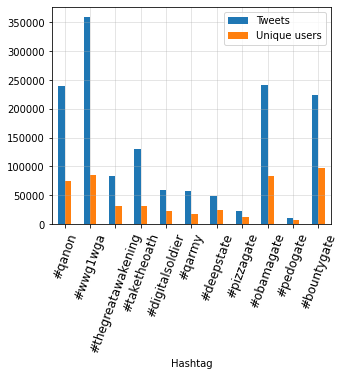

In [378]:
fig, ax = plt.subplots(figsize=(5,4))
consp_stats.plot.bar(x = 'Hashtag', y = columns[:-1], rot = 70, ax = ax)
plt.xticks(rotation=70,fontsize=12)
plt.grid(alpha=0.4)
plt.show()

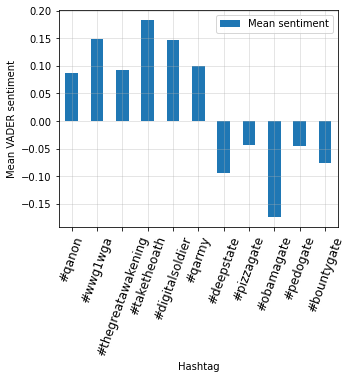

In [441]:
fig, ax = plt.subplots(figsize=(5,4))
consp_stats.plot.bar(x = 'Hashtag', y = columns[-1], rot = 70, ax = ax, label=None)
plt.xticks(rotation=70,fontsize=12)
plt.ylabel('Mean VADER sentiment')
plt.grid(alpha=0.4)
plt.show()

### Get all tweets from raw tweet files

In [66]:
clouds=False
df = pd.DataFrame()

for i, file in tqdm(enumerate(sample_files)):
    tweet_df = pd.read_csv(file,usecols=col_list)
    tweet_df.reset_index(drop=True,inplace=True)
    tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())

    orig_df = tweet_df[(tweet_df.tweet_type == 'original') | (tweet_df.tweet_type =='reply')]
    qtd_df = tweet_df[tweet_df.tweet_type == 'quoted_tweet']
    rt_df = tweet_df[tweet_df.tweet_type == 'retweeted_tweet_without_comment']

    qanon_users_orig, qanon_dict_orig, qanon_df__orig, _ = get_hashtags_orig(orig_df,qanon_keywords,cloud=clouds)
    qanon_users_qtd, qanon_dict_qtd, qanon_df__qtd, _ = get_hashtags_qtd(qtd_df,qanon_keywords,cloud=clouds)
    qanon_users_rt, qanon_dict_rt, qanon_df__rt, _ = get_hashtags_rt(rt_df,qanon_keywords,cloud=clouds)

    gate_users_orig, gate_dict_orig, gate_df__orig, _ = get_hashtags_orig(orig_df,gate_keywords,cloud=clouds)
    gate_users_qtd, gate_dict_qtd, gate_df__qtd, _ = get_hashtags_qtd(qtd_df,gate_keywords,cloud=clouds)
    gate_users_rt, gate_dict_rt, gate_df__rt, _ = get_hashtags_rt(rt_df,gate_keywords,cloud=clouds)

    df = df.append(qanon_df__orig).append(qanon_df__qtd).append(qanon_df__rt)
    df = df.append(gate_df__orig).append(gate_df__qtd).append(gate_df__rt)
    
    del tweet_df, orig_df, qtd_df, rt_df
#     del news_url_df

    gc.collect()

In [ ]:
# Use for processing all tweets from downloaded dataset

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_hashtag','rt_rt_count',
            'rt_fav_count','rt_tweetid','rt_urls_list','urls_list','qtd_hashtag',
            'qtd_urls_list','account_creation_date','sent_vader']

df = pd.DataFrame()

clouds=False

qanon_users=set()
gate_users=set()

url_dict = {}

for i, file in tqdm(enumerate(sample_files[:5])):

    tweet_df = pd.read_csv(file,usecols=col_list)
    tweet_df.reset_index(drop=True,inplace=True)
    tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
    
    orig_df = tweet_df[(tweet_df.tweet_type == 'original') | (tweet_df.tweet_type =='reply')]
    qtd_df = tweet_df[tweet_df.tweet_type == 'quoted_tweet']
    rt_df = tweet_df[tweet_df.tweet_type == 'retweeted_tweet_without_comment']
    
#     tweet_df.replace('nan',np.nan,inplace=True)

#     orig_df.hashtag = orig_df.hashtag.str.replace("'", '')
#     qtd_df.hashtag = qtd_df.hashtag.str.replace("'", '')
#     rt_df.hashtag = rt_df.hashtag.str.replace("'", '')

    qanon_users_h, qanon_dict_h, qanon_df__h = get_hashtags_tweets(tweet_df,qanon_keywords,cloud=clouds)
    conspiracy_users_h, conspiracy_dict_h, conspiracy_df__h = get_hashtags_tweets(tweet_df,conspiracy_keywords,cloud=clouds)
    gate_users_h, gate_dict_h, gate_df__h = get_hashtags_tweets(tweet_df,gate_keywords,cloud=clouds)
    
#     qanon_df_h = qanon_df_h.append(qanon_df__h)
#     conspiracy_df_h = conspiracy_df_h.append(conspiracy_df__h)
#     gate_df_h = gate_df_h.append(gate_df__h)
    
#     qanon_users.update(qanon_users_h)
#     conspiracy_users.update(conspiracy_users_h)
#     gate_users.update(gate_users_h)
    
#     tweet_df = tweet_df[tweet_df.urls_list!='[]']

#     Get tweets, create a cloud, get users associated with each news source
#     url_users, url_dict_temp, news_url_df = get_url_usertweets(tweet_df,news_sources)
#     for urlkey,urlval in url_dict_temp.items():
#         this_set = set(urlval)
#         if url_dict.get(urlkey):
#             this_set.update(url_dict.get(urlkey))
#         url_dict[urlkey]=this_set

    df = df.append(qanon_df__h)
    df = df.append(conspiracy_df__h)
    df = df.append(gate_df__h)

#     df = df.append(news_url_df)

    if i % 100 == 0:
        df.to_csv(election_path + 'election_just_consp_hashtags_1.csv', index=False)
    
    del tweet_df#, news_url_df

    gc.collect()
    
df.to_csv(election_path + 'election_just_consp_hashtags_1.csv', index=False)

In [123]:
# Use for processing all tweets from downloaded dataset

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_hashtag','rt_rt_count',
            'rt_fav_count','rt_tweetid','rt_urls_list','urls_list','qtd_hashtag',
            'qtd_urls_list','account_creation_date','sent_vader']

df = pd.DataFrame()

clouds=False

qanon_users=set()
gate_users=set()

url_dict = {}

for i, file in tqdm(enumerate(sample_files[:5])):

    tweet_df = pd.read_csv(file,usecols=col_list)
    tweet_df.reset_index(drop=True,inplace=True)
    tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
    
    orig_df = tweet_df[(tweet_df.tweet_type == 'original') | (tweet_df.tweet_type =='reply')]
    qtd_df = tweet_df[tweet_df.tweet_type == 'quoted_tweet']
    rt_df = tweet_df[tweet_df.tweet_type == 'retweeted_tweet_without_comment']
    
#     tweet_df.replace('nan',np.nan,inplace=True)
    tweet_df.hashtag = tweet_df.hashtag.str.replace("'", '')

    qanon_users_h, qanon_dict_h, qanon_df__h = get_hashtags_tweets(tweet_df,qanon_keywords,cloud=clouds)
    conspiracy_users_h, conspiracy_dict_h, conspiracy_df__h = get_hashtags_tweets(tweet_df,conspiracy_keywords,cloud=clouds)
    gate_users_h, gate_dict_h, gate_df__h = get_hashtags_tweets(tweet_df,gate_keywords,cloud=clouds)
    
#     qanon_df_h = qanon_df_h.append(qanon_df__h)
#     conspiracy_df_h = conspiracy_df_h.append(conspiracy_df__h)
#     gate_df_h = gate_df_h.append(gate_df__h)
    
#     qanon_users.update(qanon_users_h)
#     conspiracy_users.update(conspiracy_users_h)
#     gate_users.update(gate_users_h)
    
#     tweet_df = tweet_df[tweet_df.urls_list!='[]']

#     Get tweets, create a cloud, get users associated with each news source
#     url_users, url_dict_temp, news_url_df = get_url_usertweets(tweet_df,news_sources)
#     for urlkey,urlval in url_dict_temp.items():
#         this_set = set(urlval)
#         if url_dict.get(urlkey):
#             this_set.update(url_dict.get(urlkey))
#         url_dict[urlkey]=this_set

    df = df.append(qanon_df__h)
    df = df.append(conspiracy_df__h)
    df = df.append(gate_df__h)

#     df = df.append(news_url_df)

    if i % 100 == 0:
        df.to_csv(election_path + 'election_just_consp_hashtags_1.csv', index=False)
    
    del tweet_df#, news_url_df

    gc.collect()
    
df.to_csv(election_path + 'election_just_consp_hashtags_1.csv', index=False)

KeyboardInterrupt: 

In [170]:
conspiracies_df = pd.DataFrame()
for i in range(1,7):
    conspiracies_df = conspiracies_df.append(pd.read_csv(election_path + 'election_just_consp_hashtags_'+str(i)+'.csv'))
    
len(conspiracies_df)

1259758

In [171]:
conspiracies_df.to_csv(election_path + 'election_just_consp_hashtags.csv',index=False)

In [129]:
# urls_df = pd.DataFrame()
# for i in range(1,7):
#     urls_df = urls_df.append(pd.read_csv(election_path + 'election_just_news_urls_'+str(i)+'.csv'))
    
# len(urls_df)

1523163

In [130]:
# urls_df.to_csv(election_path + 'election_just_news_urls.csv',index=False)

In [132]:
urls_df.shape

(1523163, 22)

In [124]:
df

tweetid               userid      screen_name  \
18656   1274290835388055552   827749589264560128       elvondrake   
22294   1274291922270597121   827749589264560128       elvondrake   
29907   1274294134510100483   827749589264560128       elvondrake   
29748   1274294096991973376  1008517274922176514      danielmull7   
17792   1274290593913376768  1222698410064506880  barbara56840275   
...                     ...                  ...              ...   
130807  1274431538487328768   933089373557592064       kc47059011   
131078  1274431571911720961   873012295475089408   staceybjones11   
131631  1274431634134237187   781722345673220097     test55350426   
131918  1274431666270986240           1964993270     tangredierin   
132316  1274431715143016448            248886049        baratti77   

                                  date lang        location  \
18656   sat jun 20 10:39:44 +0000 2020   en             NaN   
22294   sat jun 20 10:44:04 +0000 2020   en             NaN   
29907   sat jun 20 10:52:51 +0000 2020   en             NaN   
29748   sat jun 20 10:52:42 +0000 2020   en  somewhere, usa   
17792   sat jun 20 10:38:47 +0000 2020   en            here   
...                                ...  ...             ...   
130807  sat jun 20 19:58:51 +0000 2020   en             NaN   
131078  sat jun 20 19:58:59 +0000 2020   en   united states   
131631  sat jun 20 19:59:14 +0000 2020   en    new york, ny   
131918  sat jun 20 19:59:21 +0000 2020   en             usa   
132316  sat jun 20 19:59:33 +0000 2020   en     houston, tx   

                                                     text  \
18656   (trump administration = shameless corruption) ...   
22294   (der fuhrer expands his propaganda machine.)  ...   
29907   (thank you dimwit donnie: soon there will be f...   
29748   @briankarem @realdonaldtrump trump personally ...   
17792   @ketronshawn @gorgood76 @indyspanglish @realdo...   
...                                                   ...   
130807  rt @realdonaldtrump: watch live: trump support...   
131078  rt @realdonaldtrump: watch live: trump support...   
131631  @realdonaldtrump you need to exit twitter and ...   
131918  rt @realdonaldtrump: watch live: trump support...   
132316  rt @realdonaldtrump: watch live: trump support...   

                             tweet_type followers_count favourites_count  ...  \
18656                          original             160             4944  ...   
22294                          original             160             4944  ...   
29907                          original             160             4944  ...   
29748                             reply             170            22818  ...   
17792                             reply               0               62  ...   
...                                 ...             ...              ...  ...   
130807  retweeted_tweet_without_comment            1885            26342  ...   
131078  retweeted_tweet_without_comment            1651            23478  ...   
131631                            reply               3              370  ...   
131918  retweeted_tweet_without_comment            4002            77118  ...   
132316  retweeted_tweet_without_comment             445            18398  ...   

                  hashtag                                          urls_list  \
18656                  []  [{'url': 'https://t.co/lquhiwbvns', 'expanded_...   
22294                  []  [{'url': 'https://t.co/q057enrclp', 'expanded_...   
29907   [realdonaldtrump]  [{'url': 'https://t.co/bm5me12f6y', 'expanded_...   
29748                  []  [{'url': 'https://t.co/jbemb2qf0p', 'expanded_...   
17792                  []  [{'url': 'https://t.co/t6bhmrrbxw', 'expanded_...   
...                   ...                                                ...   
130807                 []  [{'url': 'https://t.co/0nxmjzvqdt', 'expanded_...   
131078                 []  [{'url': 'https://t.co/0nxmjzvqdt', 'expanded_...   
131631  

In [50]:
# df.to_csv(election_path + 'election_conspiracies_parsed.csv', index=False)

In [52]:
print(df.shape)

(147, 21)


## Conspiracy theory wordclouds

In [383]:
def create_cloud(string,exclude = None):
    wordcloud = WordCloud(width=400,height=400,max_font_size=100, max_words=20,
                      collocations=False, background_color="white"
                          #, stopwords = exclude
                     ).generate(string)

    # Display the generated image:
    plt.figure(figsize = (5,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

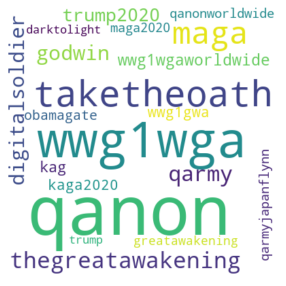


qanon num tweets: 239177
qanon unique users: 74217


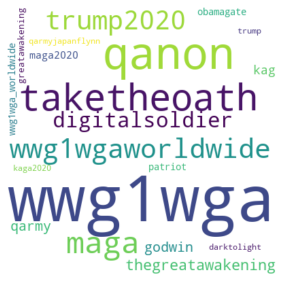


wwg1wga num tweets: 359320
wwg1wga unique users: 85334


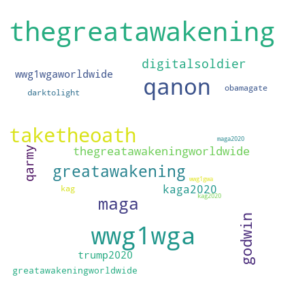


greatawakening num tweets: 83561
greatawakening unique users: 31170


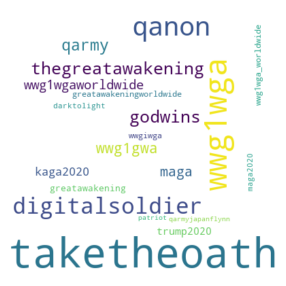


taketheoath num tweets: 129529
taketheoath unique users: 31644


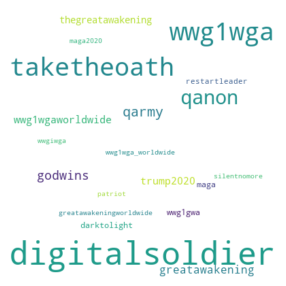


digitalsoldier num tweets: 59914
digitalsoldier unique users: 23395


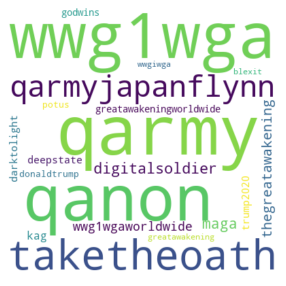


qarmy num tweets: 57582
qarmy unique users: 17738


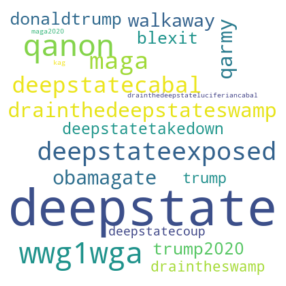


deepstate num tweets: 48625
deepstate unique users: 24110


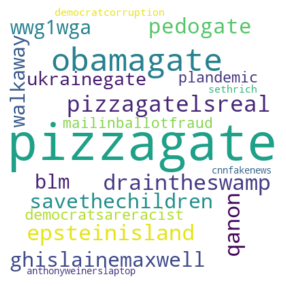


pizzagate num tweets: 23567
pizzagate unique users: 12454


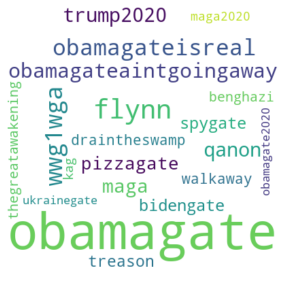


obamagate num tweets: 241888
obamagate unique users: 84143


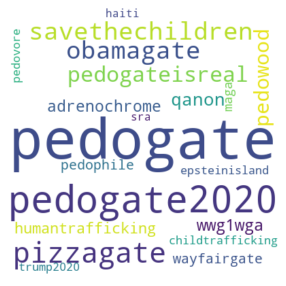


pedogate num tweets: 10827
pedogate unique users: 6674


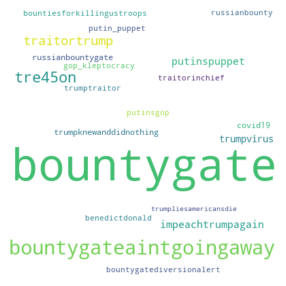


bountygate num tweets: 223568
bountygate unique users: 98115


In [386]:
# Get users associated with conspiracy theories and plot wordclouds for related hashtags
clouds=True

qanon_users_h, qanon_dict_h, qanon_df_h, qanon_dict_df_h = get_hashtags_tweets(read_df.dropna(subset=['hashtag']),qanon_keywords,cloud=clouds,printing=True)
# conspiracy_users_h, conspiracy_dict_h, conspiracy_df_h, conspiracy_dict_df_h = get_hashtags_tweets(df.dropna(subset=['hashtag']),conspiracy_keywords,cloud=clouds,printing=True)
gate_users_h, gate_dict_h, gate_df_h, gate_dict_df_h = get_hashtags_tweets(read_df.dropna(subset=['hashtag']),gate_keywords,cloud=clouds,printing=True)

In [61]:
all_consp_hashtags_df = pd.concat([qanon_df_h, gate_df_h],axis=0)
all_consp_hashtags_df.drop_duplicates(inplace=True)

In [62]:
print('Unique qanon conspiracy tweeters:      ',len(list(set(qanon_users_h))))
# print('Unique conspiracy tweeters:            ',len(list(set(conspiracy_users_h))))
print('Unique gate conspiracy tweeters:       ',len(list(set(gate_users_h))))

Unique qanon conspiracy tweeters:       132843
Unique gate conspiracy tweeters:        190907


In [66]:
len(url_dict['msnbc'])

15907

## Conspiracy keywords in tweet text

Looking at the tweet text instead of hashtags

In [49]:
conspiracy_users, conspiracy_dict, consps_df = get_text_tweets(df,keywords)
qanon_users, qanon_dict, qanon_df = get_text_tweets(df,qanon_keywords)

In [50]:
all_consp_text_df = pd.concat([qanon_df],axis=0)
all_consp_text_df.drop_duplicates(inplace=True)

In [48]:
print('Unique conspiracy tweeters:            ', len(list(set(conspiracy_users))))
print('Unique qanon conspiracy tweeters:      ', len(list(set(qanon_users))))

Unique conspiracy tweeters:             0
Unique qanon conspiracy tweeters:       2556


## News urls and conspiracies

In [392]:
# Urls and number of users
url_keys = url_dict.keys()
url_tots = [len(i) for i in url_dict.values()]

In [393]:
# All tweeters who tweet using conspiracy theo = list(set(list(qanon_users))) + list(set(list(gate_users)))
len(all_consp_users)

132843

In [397]:
url_dict.keys()

dict_keys(['msnbc', 'nydailynews', 'reuters', 'foxnews', 'cnn', 'wsj', 'huffpost', 'nyt', 'dailymail', 'washingtonpost', 'theguardian', 'abcnews', 'bbc', 'usatoday', 'infowars', 'oann', 'latimes', 'cnbc', 'boston', 'yahoo', 'chicagotribune', 'msn', 'breitbart'])

In [391]:
print(len(qanon_users_h))
print(len(gate_users_h))

132843
190907


In [415]:
# Generates a plot of conspiracy users and their proportion who link to news urls
def plot_proportion_url_consp(user_set, user_cat):
        
    # Number of general (non conspiracy) tweeters who use urls from each sources
    num_url_general = {}
    for key,value in url_dict.items():
        num_url_general[key] = len(list(url_dict[key]))
        
    # Number of users who use urls from each sources who tweet conspiracy theories
    num_url_consp = {}
    for key,value in url_dict.items():
        num_url_consp[key] = len((set(url_dict[key]).intersection(user_set)))
        
    url_consp_values = list(num_url_consp.values())
    
    url_props = []
    for key in num_url_general.keys():
        url_props.append(num_url_consp[key]/num_url_general[key])
    
    sorted_urls = sorted([(i, j) for i , j in zip(url_props, url_keys)], key = lambda x : x[1])
    
    plt.figure(figsize=(12,5))
    plt.title('Proportion of users linking news websites and using '+ user_cat +' hashtags',size=15)
    plt.bar([i[1] for i in sorted_urls],[i[0] for i in sorted_urls])
    plt.xticks(rotation=75,fontsize=14)
    plt.grid(alpha = 0.4)
    plt.show()
    
    return sorted_urls

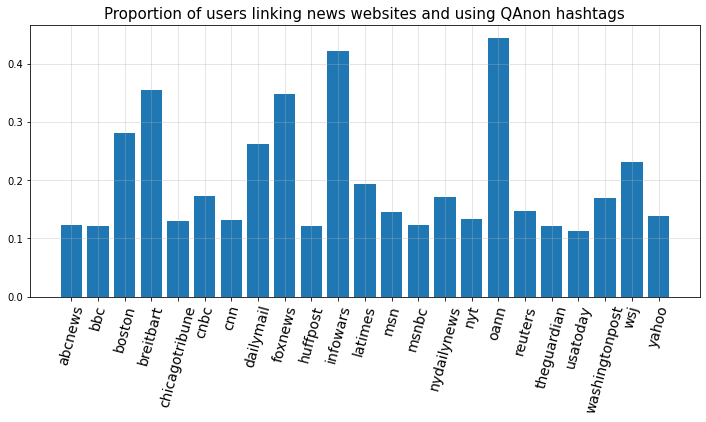

In [417]:
q_url_props = plot_proportion_url_consp(set(qanon_users_h), 'QAnon')

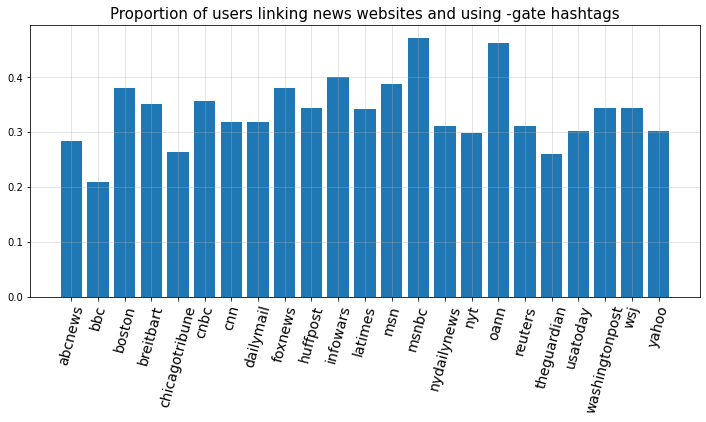

In [418]:
g_url_props = plot_proportion_url_consp(set(gate_users_h), '-gate')

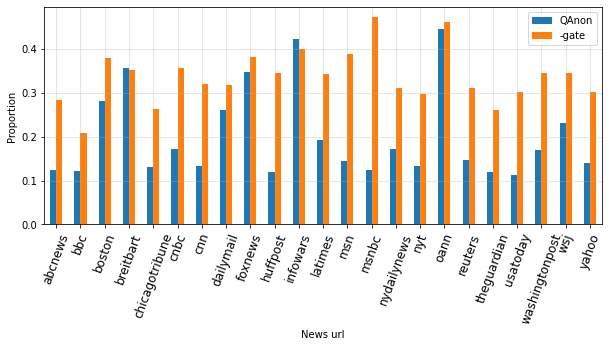

In [443]:
url_proportions = pd.merge(pd.DataFrame(q_url_props,columns=['QAnon', 'News url']),
         pd.DataFrame(g_url_props,columns=['-gate', 'News url']), 
         how='left', on ='News url').set_index('News url').reset_index()

fig, ax = plt.subplots(figsize=(10,4))
# plt.title('Proportion of users linking news websites and using QAnon and -gate hashtags',size=15)
url_proportions.plot.bar(x = 'News url', y = ['QAnon','-gate'], rot = 70, ax = ax)
plt.ylabel('Proportion')
plt.xticks(rotation=70,fontsize=12)
plt.grid(alpha=0.4)
plt.show()

In [422]:
g_url_props

[(0.2835016835016835, 'abcnews'),
 (0.20850771082955913, 'bbc'),
 (0.38041985481655877, 'boston'),
 (0.351467890705822, 'breitbart'),
 (0.2635005744925316, 'chicagotribune'),
 (0.3567479008806062, 'cnbc'),
 (0.3192655767617279, 'cnn'),
 (0.3185827588762879, 'dailymail'),
 (0.38055311296335287, 'foxnews'),
 (0.34421446658592975, 'huffpost'),
 (0.3998330550918197, 'infowars'),
 (0.34193057668372284, 'latimes'),
 (0.3875708385361637, 'msn'),
 (0.47180486578236, 'msnbc'),
 (0.31074168797953966, 'nydailynews'),
 (0.29843922251232957, 'nyt'),
 (0.46161898115840894, 'oann'),
 (0.31053723089077623, 'reuters'),
 (0.26053219937749333, 'theguardian'),
 (0.3027288345519198, 'usatoday'),
 (0.34472967626317874, 'washingtonpost'),
 (0.3444311597535179, 'wsj'),
 (0.30116664266167364, 'yahoo')]

In [157]:
# Heatmap matrix for each news website as proportion on users who also link to specific news sites
user_consp_dict = {'qanon':qanon_users,'pizza':gate_users}
# user_consp_dict = {'qanon':qanon_users}

heatmap_matrix = np.zeros((len(url_dict),len(user_consp_dict)))

for i,(urlkey,urlval) in enumerate(url_dict.items()):
    for j,(userkey,userval) in enumerate(user_consp_dict.items()):
        heatmap_matrix[i,j] = len((set(urlval).intersection(set(userval))))/(len(userval)*len(urlval))*100*100

In [158]:
num_user_keys = [consp + '\n' + str(len(user_consp_dict[consp])) + ' users' for consp in user_consp_dict.keys()]

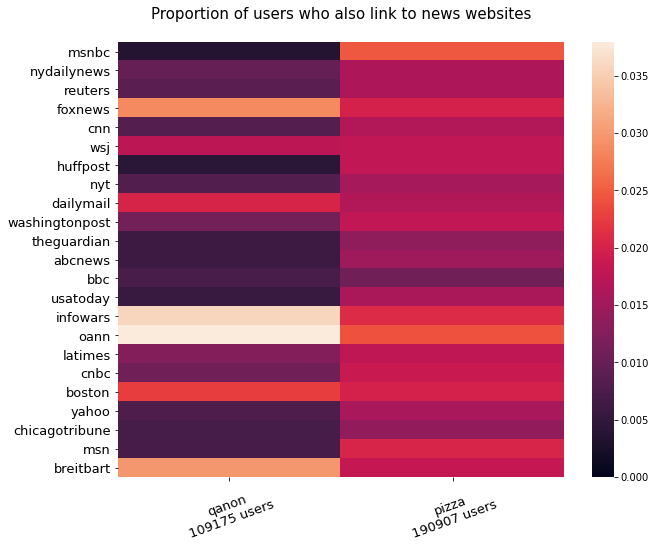

In [159]:
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_matrix, xticklabels=num_user_keys, yticklabels=news_sources,vmin=0)
plt.title('Proportion of users who also link to news websites\n',fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(rotation=20,fontsize=13)
plt.show()

### Drill down on bots

In [224]:
# general_botscores = 0

In [120]:
# Include non conspiracy theory users
user_consp_dict = {'qanon':qanon_users}
num_user_keys = [consp + '\n' + str(len(user_consp_dict[consp])) + ' users' for consp in user_consp_dict.keys()]

In [226]:
heatmap_matrix_bots = np.zeros((len(url_dict),len(user_consp_dict)))

for i,(urlkey,urlval) in enumerate(url_dict.items()):
    for j,(userkey,userval) in enumerate(user_consp_dict.items()):
        
        users = list(set(urlval).intersection(set(userval)))
        score_list = []
        for user in users:
            if all_botdict_en.get(user):
                score_list.append(all_botdict_en.get(user))
        if len(score_list) > 10:
            heatmap_matrix_bots[i,j] = sum(score_list)/len(score_list)
        else:
            heatmap_matrix_bots[i,j] = np.mean(list(all_botdict_en.values()))
        

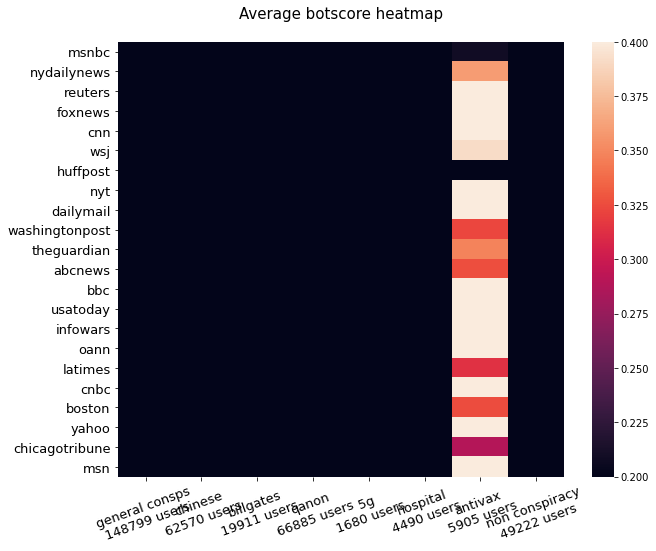

In [227]:
plt.figure(figsize=(10,8))
plt.title('Average botscore heatmap\n',fontsize=15)
sns.heatmap(heatmap_matrix_bots, xticklabels=num_user_keys, yticklabels=news_sources,vmax=0.4,vmin=0.2)
plt.yticks(fontsize=13)
plt.xticks(rotation=20,fontsize=13)
plt.show()

### Frequency plot of urls
General compared to conspiracy dataset

In [129]:
# Gets a dictionary of number of times urls are used above a threshold value
def get_url_counts(df,num_urls):
    url_df = df[df.urls_list != '[]'].reset_index()
    url_freq = [] 
    for i, row in url_df.iterrows():
        for url in ast.literal_eval(row.urls_list):
            url_freq.append(url['display_url'].split('/')[0])
            
    url_counts = Counter(url_freq)
    sorted_urls = {k: v for k, v in sorted(url_counts.items(), key=lambda item: item[1],reverse=True)[:num_urls]}
    print(sorted_urls)
    return sorted_urls

In [130]:
sorted_control_urls = get_url_counts(tot_df,30)
# sorted_control_urls = get_url_counts(control_df,30)
sorted_consp_urls = get_url_counts(df,30)
# sorted_consp_urls = get_url_counts(df,30)

{'twitter.com': 953012, 'youtu.be': 95680, 'pscp.tv': 46548, 'foxnews.com': 39465, 'youtube.com': 38644, 'breitbart.com': 37547, 'iwillvote.com': 33101, 'nytimes.com': 28075, 'cbsnews.com': 15376, 'cnn.com': 15074, 'facebook.com': 14900, 'google.com': 14338, 'washingtonpost.com': 13791, 'bit.ly': 13247, 'mobile.twitter.com': 9037, 'apple.news': 7654, 'joebiden.com': 7508, 'rawstory.com': 7253, 'businessinsider.com': 7047, 'm.youtube.com': 6753, 'theguardian.com': 6708, 'nbcnews.com': 6348, 'forbes.com': 6174, 'thehill.com': 5966, 'theconservativetreehouse.com': 5059, 'washingtontimes.com': 4981, 'thegatewaypundit.com': 4795, 'politico.com': 4792, 'apnews.com': 4379, 'thedcpatriot.com': 4210}
{'breitbart.com': 270409, 'cnn.com': 160695, 'foxnews.com': 158699, 'washingtonpost.com': 148602, 'nytimes.com': 121141, 'twitter.com': 114972, 'theguardian.com': 40759, 'google.com': 40003, 'msnbc.com': 37485, 'usatoday.com': 31519, 'cnbc.com': 30010, 'huffpost.com': 29998, 'wsj.com': 24698, 'news

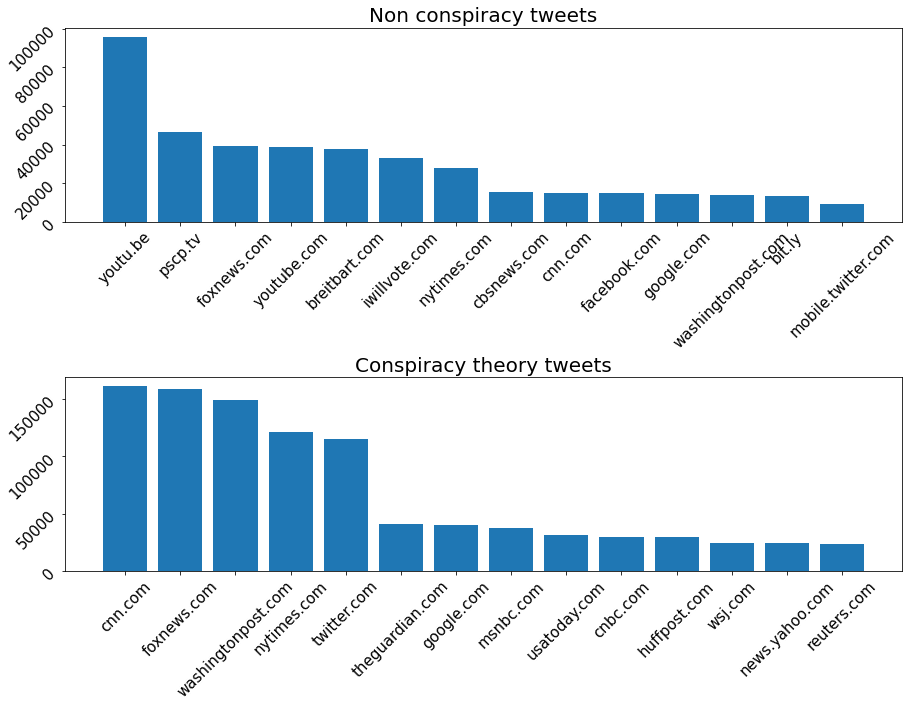

In [123]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].bar(list(sorted_control_urls.keys())[1:15], list(sorted_control_urls.values())[1:15])
ax[0].set_title('Non conspiracy tweets',fontsize=20)
ax[1].bar(list(sorted_consp_urls.keys())[1:15], list(sorted_consp_urls.values())[1:15])
ax[1].set_title('Conspiracy theory tweets',fontsize=20)
ax[0].tick_params(labelrotation=45,labelsize=15)
ax[1].tick_params(labelrotation=45,labelsize=15)
plt.subplots_adjust(hspace = 0.8)
plt.show()

### Temporal analysis

In [444]:
# Maps tweet df date record to pd.Timestamp
def get_date(x):
    date_parts = x.split(' ')
    date = '-'.join([date_parts[1]] + [date_parts[2]] + [date_parts[5]])
    return pd.Timestamp(date)

In [445]:
# # Maps tweet df date and hour record to pd.Timestamp
def get_date_hour(x):
    date_parts = x.split(' ')
    if len(date_parts) < 5:
        return pd.Timestamp('00:00:00')
    date = '-'.join([date_parts[1]] + [date_parts[2]] + [date_parts[5]]) 
    date = pd.Timestamp(date) + pd.Timedelta(hours = int(date_parts[3][0:2]))
    return date

# dates_df = df.date.apply(get_date_hour)

In [450]:
df.date = df.date.apply(get_date)

In [451]:
df.date.min()

Timestamp('2020-06-20 00:00:00')

In [452]:
# Create placeholder df for dates
date_df = pd.DataFrame(columns=all_keywords,index=pd.date_range(start=df.date.min(),end=df.date.max()))
date_df.fillna(0,inplace=True)

# Fill df
for consp_name in all_keywords:
    consp_df = qanon_dict_df_h.get(consp_name)
    if type(consp_df) != pd.DataFrame:
        consp_df = gate_dict_df_h.get(consp_name)

    dates = consp_df.date.apply(get_date)
    for date in dates.values:
        date_df.loc[date,consp_name] += 1

date_df.describe()

qanon       wwg1wga  greatawakening   taketheoath  \
count     79.000000     79.000000       79.000000     79.000000   
mean    3027.556962   4548.354430     1057.734177   1639.607595   
std     2908.614388   4713.613302     1814.355517   4197.799458   
min      844.000000   1056.000000      285.000000      0.000000   
25%     1276.000000   1809.500000      499.000000     59.500000   
50%     1785.000000   2627.000000      633.000000    161.000000   
75%     3631.500000   5029.000000      932.000000    463.000000   
max    20741.000000  31338.000000    15524.000000  30084.000000   

       digitalsoldier        qarmy    deepstate    pizzagate     obamagate  \
count       79.000000    79.000000    79.000000    79.000000     79.000000   
mean       758.405063   728.886076   615.506329   298.316456   3061.873418   
std       1490.521725   780.075161   275.943829   174.052861   1994.774143   
min         55.000000   121.000000   258.000000    49.000000   1042.000000   
25%        136.500000   294.500000   429.500000   172.000000   1580.500000   
50%        226.000000   467.000000   565.000000   281.000000   2624.000000   
75%        546.000000   850.000000   734.500000   393.500000   3793.000000   
max       9434.000000  5191.000000  1803.000000  1015.000000  12222.000000   

         pedogate    bountygate  
count   79.000000     79.000000  
mean   137.050633   2829.974684  
std     77.914631   3865.610447  
min     34.000000      0.000000  
25%     81.000000    577.500000  
50%    132.000000   1232.000000  
75%    177.000000   3567.500000  
max    571.000000  21127.000000

In [461]:
# Get subset of data
new_cols = list(date_df.sum().nlargest(4).index)[::2] + list(date_df.sum().nlargest(4).index)[1::2]
# short_date_df = date_df[list(date_df.sum().nlargest(4).index)]
short_date_df = date_df[new_cols]
short_date_df

wwg1wga  qanon  obamagate  bountygate
2020-06-20     4510   2497       1473           0
2020-06-21     5789   3607       2491           0
2020-06-22     4345   5135       2639           0
2020-06-23     4822   4021       5037           0
2020-06-24     5739   5017      10842           0
...             ...    ...        ...         ...
2020-09-02     1160   1012       1366         561
2020-09-03     1056    880       1266        7537
2020-09-04     1083   1108       1207        9503
2020-09-05     1308   1684       1047        3714
2020-09-06     1660   1209       1491        7231

[79 rows x 4 columns]

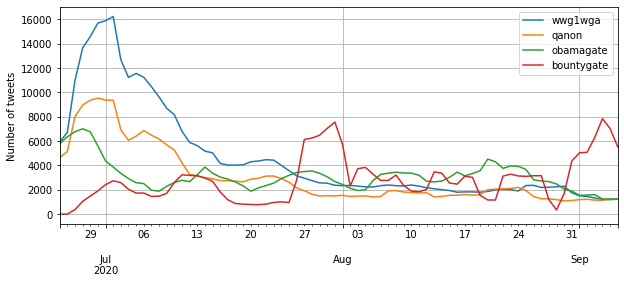

In [462]:
# Smoothed volume of consp hashtags over time
rolling_mean = short_date_df.rolling(6).mean().dropna()
rolling_mean.plot(y=short_date_df.columns,use_index=True,figsize=(10,4),fontsize=10)
plt.ylabel('Number of tweets')
# plt.title('Conspiracy theory related tweets timeline')
plt.grid()

# Bot analysis

## Get user handles for botometer

Getting screen names to query using Botometer

In [38]:
account_totals = df[['userid','screen_name']].groupby(['userid','screen_name']).size()
account_totals.sort_values(ascending=False)

KeyboardInterrupt: 

In [131]:
account_totals = account_totals.sort_values(ascending=False)

/Users/jaimin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [118]:
url_props = [vals/tots for vals,tots in zip(url_consp_values,url_tots)]

In [200]:
# Get botometer scores for a list
def botometer_query(counter, handles, csv_name):
    rapidapi_key = "6ac8fe69aamshcc30411e7824b49p12a1cajsnc2267278951c"
    twitter_app_auth = {
        'consumer_key':'MmWATyoHu9GdouoNuZNuzzWbi',
        'consumer_secret': 'iYZRcgnKzBZ5GlzBe4olGXBtBT8t0p6K99JeUIeKvPIqBLQk9l',
        'access_token': '1239432784319406080-vuGIvDzEWj6j6EL57427FHnDTipljz',
        'access_token_secret': 'ISafXRzVjGSQc46mjNtMgMXZl3ry9wDmMHiHRVzsMlX60',
      }

    botometer_api_url = 'https://botometer-pro.p.rapidapi.com'
    bom = botometer.Botometer(botometer_api_url=botometer_api_url,
                              wait_on_ratelimit=True,
                              rapidapi_key=rapidapi_key,
                              **twitter_app_auth)

    daily_lim = 0
    this_acc = ''
    start_day = time.time()

    while counter < len(handles):
        try:
            for screen_name, result in bom.check_accounts_in(handles[counter:]):

                this_acc = screen_name
                with open('Botometer_results/' + csv_name + '.csv', 'a+') as file:
                    file.write('%s\n' % json.dumps(result))
                counter += 1
                daily_lim += 1

                if daily_lim >= 35000:
                    print('Reaced daily max')
                    now = time.time()
                    sleep_secs = 24 *60**2 - (now-start_day)

                    if sleep_secs > 0:
                        time.sleep(sleep_secs)

                    daily_lim = 0
                    start_day = time.time()

        except:
            print('\nSleeping on: ', str(counter),'  ' + this_acc)
            time.sleep(5)

## Load botscore queries

In [313]:
# Returns a list of jsons of each uesr
def read_bot_csv(csv_name):
    file = open(csv_name)
    return file.readlines()

In [314]:
def get_antivax_botscores(df):
    cols = ['screen_name', 'english_botscore']
    user_scores = pd.DataFrame(columns = cols)
    for i in range(len(df)):
        botjson = json.loads(df.iloc[i].json)
        if botjson.get('user').get('user_data'):
            user_scores = user_scores.append(pd.DataFrame({'screen_name':[botjson['user']['user_data']['screen_name']].lower(), 
                                     'english_botscore':[botjson['cap']['english']]}))
        else:
            user_scores = user_scores.append(pd.DataFrame({'screen_name':[botjson['user']['screen_name']].lower(), 
                                     'english_botscore':[botjson['cap']['english']]}))
    user_scores.reset_index(inplace=True,drop=True)
    return user_scores

In [315]:
# Get dictionary of botscores from list of botometer json
def users_dict(json_list):
    bot_dict = {}
    for user in json_list:
        this_user = json.loads(user)
        if this_user.get('user'):
            if this_user.get('user').get('user_data'):
                bot_dict[this_user['user']['user_data']['screen_name'].lower()] = this_user['display_scores']['english']['overall']
            else:
                bot_dict[this_user['user']['screen_name'].lower()] = this_user['display_scores']['english']
    return bot_dict

## Herberts bot scores

In [320]:
botfile_path = '../'
botscore_df = pd.read_csv(botfile_path + 'herbert_results.csv')
botscore_df.screen_name = botscore_df.screen_name.str.lower()
print(botscore_df.shape)

(3560190, 4)


## Old bot scores

In [38]:
botfile_path = 'Botometer_results/election/'
bot_consp_df = pd.read_csv(botfile_path + 'qanon_pizza_users.csv')
bot_consp_df.dropna(inplace=True)
print(bot_consp_df.shape)

bot_general_df = pd.read_csv(botfile_path + 'control_election_users.csv')
bot_general_df.dropna(inplace=True)
print(bot_general_df.shape)

(1216, 33)
(894, 33)


In [39]:
botscore_files = [botfile_path + i for i in os.listdir(botfile_path) if i[-3:] == 'csv']
print(botscore_files)
all_botscores = []
all_botdict_en = {}
for botfile in botscore_files:
#     if botfile.startswith('Botometer_results/antivax_results_jsons'):
#         continue
#     elif botfile.startswith('Botometer_results/antivax'):
#         these_botscores = read_bot_csv(botfile)

    these_botscores = read_bot_csv(botfile)
    all_botdict_en.update(users_dict(these_botscores))
    all_botscores += these_botscores

['Botometer_results/election/qanon_pizza_users.csv', 'Botometer_results/election/control_election_users.csv']


In [40]:
print('Number of botscores:',len(all_botscores))
print('Number of botscores:',len(all_botdict_en))

Number of botscores: 2355
Number of botscores: 2110


In [41]:
control_bot_files = [i for i in botscore_files if 'control' in i]
control_botscores = {}

for file in control_bot_files:
    these_scores = read_bot_csv(file)
    control_botscores.update(users_dict(these_scores))
len(control_botscores)

893

In [42]:
consp_bot_files = [i for i in botscore_files if 'control' not in i]
consp_botscores = {}

for file in consp_bot_files:
    these_scores = read_bot_csv(file)
    consp_botscores.update(users_dict(these_scores))

In [43]:
len(consp_botscores)

1217

In [44]:
print('Non conspiracy avg botscore:',sum(control_botscores.values())/ len(control_botscores))
print('Conspiracy avg botscore:',sum(consp_botscores.values())/ len(consp_botscores))

Non conspiracy avg botscore: 0.6101071894340465
Conspiracy avg botscore: 0.7377033377697653


In [45]:
# For url users for baseline comparison
url_bot_files = ['Botometer_results/botometer_general_06_03_unfinished.csv',
                  'Botometer_results/botometer_general_url - Copy.csv',
                  'Botometer_results/botometer_general_url_2 - Copy.csv',
                  'Botometer_results/url_general_bot_queries.csv',
                ]

url_bot_files = [
                  'Botometer_results/botometer_general_url - Copy.csv',
                  'Botometer_results/botometer_general_url_2 - Copy.csv',
                  'Botometer_results/url_general_bot_queries.csv',
                ]

url_botscores = {}

for file in url_bot_files:
    these_scores = read_bot_csv(file)
    url_botscores.update(users_dict(these_scores))

In [47]:
# # # Find Conspiracy theory users
# rt_scored_users = list(rt_df[rt_df['screen_name'].isin(set(all_botdict_en.keys()))].screen_name.unique())
# orig_scored_users = list(orig_df[orig_df['screen_name'].isin(set(all_botdict_en.keys()))].screen_name.unique())

In [202]:
# Get lists of scores
rt_scores = []
orig_scores = []
for name in rt_scored_users:
    rt_scores.append(all_botdict_en[name])
for name in orig_scored_users:
    orig_scores.append(all_botdict_en[name])

## Botscore Results

In [48]:
print(sum(rt_scores)/len(rt_scores))
print(sum(orig_scores)/len(orig_scores))

NameError: name 'rt_scores' is not defined

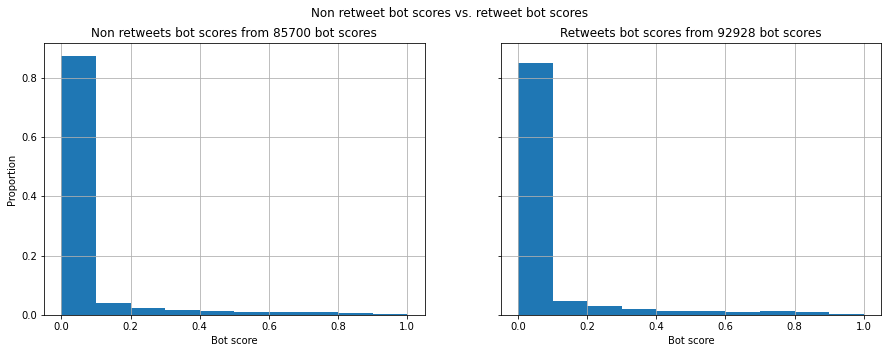

In [204]:
# Bot scores
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
fig.suptitle('Non retweet bot scores vs. retweet bot scores')
ax[0].set_ylabel('Proportion')
ax[0].set_xlabel('Bot score')

ax[0].hist(orig_scores, weights=np.ones(len(orig_scores))/len(orig_scores))
ax[0].set_title('Non retweets bot scores from %d bot scores' % len(orig_scores))
ax[0].grid()

ax[1].set_xlabel('Bot score')
ax[1].hist(rt_scores, weights=np.ones(len(rt_scores))/len(rt_scores))
ax[1].set_title('Retweets bot scores from %d bot scores' % len(rt_scores))
ax[1].grid()
plt.show()

In [205]:
# Comparing botscores for conspiracy theories vs non conspiracy theoies
botvals_general = list(general_botscores.values())
botvals_consp = list(consp_botscores.values())

In [206]:
print('General',sum(botvals_general)/len(botvals_general))
print('Conspiracy',sum(botvals_consp)/len(botvals_consp))

General 0.053641498434632444
Conspiracy 0.06980268171802326


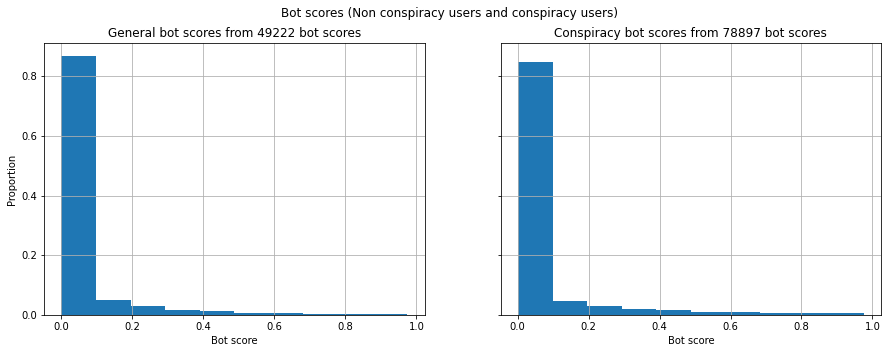

In [207]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
fig.suptitle('Bot scores (Non conspiracy users and conspiracy users)')

ax[0].set_ylabel('Proportion')
ax[0].set_xlabel('Bot score')
ax[0].hist(botvals_general, weights=np.ones(len(botvals_general)) / len(botvals_general))
ax[0].set_title('General bot scores from %d bot scores' % len(botvals_general))
ax[0].grid()

ax[1].set_xlabel('Bot score')
ax[1].hist(botvals_consp, weights=np.ones(len(botvals_consp)) / len(botvals_consp))
ax[1].set_title('Conspiracy bot scores from %d bot scores' % len(botvals_consp))
ax[1].grid()
plt.show()

In [208]:
non_consp_users = set(list(general_botscores.keys()))

In [209]:
# Get botscores for each conspiracy theory
all_botdict_en_china = {}
all_botdict_en_bill = {}
all_botdict_en_qanon = {}
all_botdict_en_hosp = {}
all_botdict_en_fiveg = {}
all_botdict_en_antivax = {}
all_botdict_en_non_consp = {}

# all_botuser_set = set(all_botdict_en.keys())
for screen_name in all_botdict_en.keys():
    if screen_name in china_users:
        all_botdict_en_china[screen_name] = all_botdict_en[screen_name]
    if screen_name in bill_users:
        all_botdict_en_bill[screen_name] = all_botdict_en[screen_name]
    if screen_name in qanon_users:
        all_botdict_en_qanon[screen_name] = all_botdict_en[screen_name]
    if screen_name in hosp_users:
        all_botdict_en_hosp[screen_name] = all_botdict_en[screen_name]
    if screen_name in fiveg_users:
        all_botdict_en_fiveg[screen_name] = all_botdict_en[screen_name]
    if screen_name in antivax_users:
        all_botdict_en_antivax[screen_name] = all_botdict_en[screen_name]
    if screen_name in non_consp_users:
        all_botdict_en_non_consp[screen_name] = all_botdict_en[screen_name]
    
print(len(all_botdict_en_china))
print(len(all_botdict_en_bill))
print(len(all_botdict_en_qanon))
print(len(all_botdict_en_hosp))
print(len(all_botdict_en_fiveg))
print(len(all_botdict_en_antivax))
print(len(all_botdict_en_non_consp))

33356
6748
25125
3233
911
2441
49222


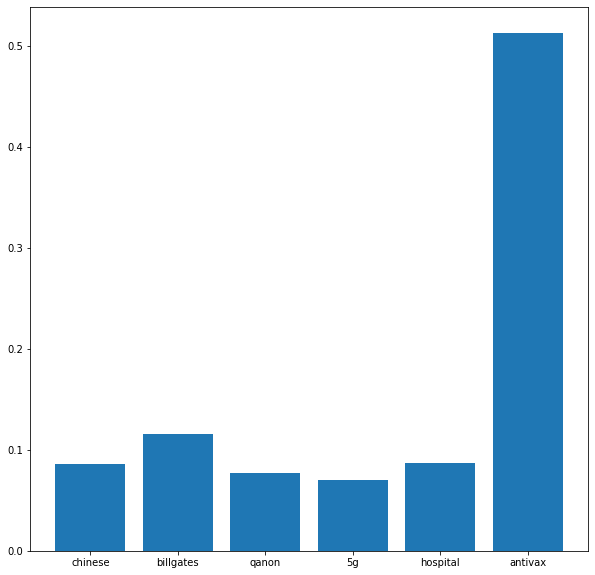

In [211]:
# Average botscore for each group of conspiracy theory users
fig = plt.figure(figsize = (10,10))

avg_botscores= [sum(list(all_botdict_en_china.values()))/len(all_botdict_en_china.values()),
                sum(list(all_botdict_en_bill.values()))/len(all_botdict_en_bill.values()),
                sum(list(all_botdict_en_qanon.values()))/len(all_botdict_en_qanon.values()),
                sum(list(all_botdict_en_hosp.values()))/len(all_botdict_en_hosp.values()),
                sum(list(all_botdict_en_fiveg.values()))/len(all_botdict_en_fiveg.values()),
                sum(list(all_botdict_en_antivax.values()))/len(all_botdict_en_antivax.values())]
#                 sum(list(all_botdict_en_non_consp.values()))/len(all_botdict_en_non_consp.values())]

plt.bar(list(user_consp_dict.keys())[1:],avg_botscores)

plt.show()

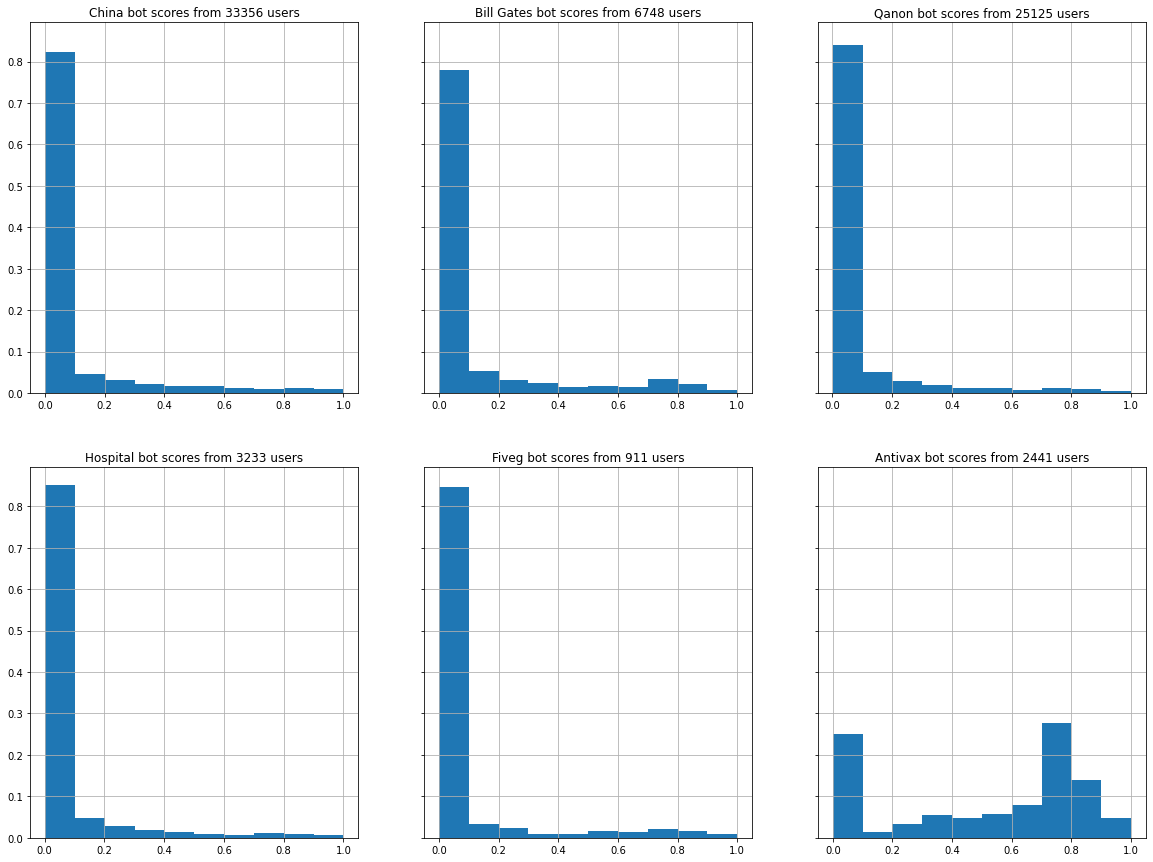

In [212]:
fig, ax = plt.subplots(2,3,figsize=(20,15) ,sharey=True)

ax[0,0].hist(all_botdict_en_china.values(), weights=np.ones(len(all_botdict_en_china)) / len(all_botdict_en_china))
ax[0,0].set_title('China bot scores from %d users' % len(all_botdict_en_china))
ax[0,0].grid()

ax[0,1].hist(all_botdict_en_bill.values(), weights=np.ones(len(all_botdict_en_bill)) / len(all_botdict_en_bill))
ax[0,1].set_title('Bill Gates bot scores from %d users' % len(all_botdict_en_bill))
ax[0,1].grid()

ax[0,2].hist(all_botdict_en_qanon.values(), weights=np.ones(len(all_botdict_en_qanon)) / len(all_botdict_en_qanon))
ax[0,2].set_title('Qanon bot scores from %d users' % len(all_botdict_en_qanon))
ax[0,2].grid()

ax[1,0].hist(all_botdict_en_hosp.values(), weights=np.ones(len(all_botdict_en_hosp)) / len(all_botdict_en_hosp))
ax[1,0].set_title('Hospital bot scores from %d users' % len(all_botdict_en_hosp))
ax[1,0].grid()

ax[1,1].hist(all_botdict_en_fiveg.values(), weights=np.ones(len(all_botdict_en_fiveg)) / len(all_botdict_en_fiveg))
ax[1,1].set_title('Fiveg bot scores from %d users' % len(all_botdict_en_fiveg))
ax[1,1].grid()

ax[1,2].hist(all_botdict_en_antivax.values(), weights=np.ones(len(all_botdict_en_antivax)) / len(all_botdict_en_antivax))
ax[1,2].set_title('Antivax bot scores from %d users' % len(all_botdict_en_antivax))
ax[1,2].grid()

plt.show()

# Find significant users

## Original Tweets

In [201]:
# Only include original tweets
all_df = orig_df[orig_df.tweet_type == 'original']
all_df.dropna(subset=['hashtag'],inplace=True)
all_df[['followers_count','favourites_count']] = all_df[['followers_count','favourites_count']].astype('float')

/Users/jaimin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [202]:
bill_df = all_df[all_df['screen_name'].isin(bill_users)]
fiveg_df = all_df[all_df['screen_name'].isin(fiveg_users)]
china_df = all_df[all_df['screen_name'].isin(china_users)]
hosp_df = all_df[all_df['screen_name'].isin(hosp_users)]

### By follower count

In [203]:
print(bill_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
bill_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['dalenekurtis' 'jamierodr14' 'libertytarian' 'no_democrats' 'kidkool4u'
 'hickorymtnman' 'bamafanaticfan1' 'sherry25793049' 'tmzedg'
 'eavesdropann' 'christinepolon1' 'stephphilip8' 'notunderdog'
 'jpharley3000' 'enki74' 'yourauntiemame' 'toscaausten' 'chesleydohl'
 'jebeess34' 'viku1111']


tweetid              userid      screen_name  \
129868   1222517778973851649           244241866     dalenekurtis   
1423373  1238975687790415872          3353061012      jamierodr14   
2156944  1252710238656040969           590211920    libertytarian   
307205   1224689435226394626            59461030     no_democrats   
2342953  1255668392972955649          2827135812        kidkool4u   
2291235  1254775975222456321  914154046382051328    hickorymtnman   
2155183  1252698632895311877  997312910748680192  bamafanaticfan1   
1182755  1235040423002992640  949672435690934274   sherry25793049   
2138593  1252395308660613120  996576181251117056           tmzedg   
2268906  1254380037232635904           134240162     eavesdropann   

                                   date lang                        location  \
129868   wed jan 29 13:52:06 +0000 2020   en  newport beach,ca•nashville,tn    
1423373  sat mar 14 23:49:57 +0000 2020   en                         georgia   
2156944  tue apr 21 21:26:09 +0000 2020   en                              tx   
307205   tue feb 04 13:41:29 +0000 2020   en                             usa   
2342953  thu apr 30 01:20:48 +0000 2020   en                 toronto, on, ca   
2291235  mon apr 27 14:14:39 +0000 2020   en                             NaN   
2155183  tue apr 21 20:40:02 +0000 2020   en                              tx   
1182755  wed mar 04 03:12:37 +0000 2020   en                     chicago, il   
2138593  tue apr 21 00:34:44 +0000 2020   en                    columbus, oh   
2268906  sun apr 26 12:01:20 +0000 2020   en                 michigan u.s.a.   

                                                      text tweet_type  \
129868   coronavirus infected are trying to spread the ...   original   
1423373  boom! \n\ntrump was right! \n\nthe fake news m...   original   
2156944  connecticut — always first in tyranny\n\n#soci...   original   
307205   figure out who really owns cnn and msnbc and c...   original   
2342953  must watch! #covid19 #plandemic https://t.co/g...   original   
2291235  warning friends\n\nthere are shortages coming ...   original   
2155183  senate leaders reach agreement on $500b 'phase...   original   
1182755  dr. drew: media-driven panic over coronavirus ...   original   
2138593  as more data comes in showing\ncoved19 is far ...   original   
2268906  steve bannon on holding china accountable for ...   original   

         followers_count  favourites_count verified  \
129868          197669.0           32921.0     True   
1423373         132299.0          451068.0    False   
2156944         127236.0            7222.0    False   
307205           81811.0            6696.0    False   
2342953          54052.0          144021.0    False   
2291235          52893.0           84838.0    False   
2155183          49368.0           89770.0    False   
1182755          46781.0          190454.0    False   
2138593          46071.0           26143.0    False   
2268906          44954.0            2038.0    False   

                                                   hashtag  \
129868                                       [cononavirus]   
1423373                                                 []   
2156944         [socialdistancing, constitutiondistancing]   
307205   [exposecnn, facebook, deepstate, exposemsnbc, ...   
2342953                               [covid19, plandemic]   
2291235                                                 []   
2155183                                                 []   
1182755                                                 []   
2138593                                                 []   
2268906                                                 []   

                                                 urls_list  \
129868   [{'url': 'https://t.co/zr5xrgyags', 'expanded_...   
1423373  [{'url': 'https://t.co/otpjpngzej', 'expanded_...   
2156944  [{'url': 'https://t.co/hfydwkz5qr', 'expanded_...   
307205                                 

In [164]:
print(china_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# china_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['jagrannews' 'tarekfatah' 'mrsgandhi' 'edoilustrado' 'epochtimes'
 'joshrogin' 'presstv' 'mikandynothem' 'danielmaithyake' 'gatimumuchai'
 'sasscbrown' 'davidwebbshow' 'amerikangirlll' 'adammilstein'
 'jenniferatntd' 'cofekrebranded' 'jkylebass' 'jamierodr14' 'rwang0'
 'erotao']


In [165]:
print(fiveg_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# fiveg_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['financialxpress' 'jonbenjamin19' 'paoloigna1' 'adjunctprofesor'
 'thelastpiratela' 'no_democrats' 'honourablehappy' 'seefinish' 'viku1111'
 'worldnewsdotcom' 'gizmothegreates' 'photoframd' 'hsnewslive' 'jhsty'
 'cvonpetzholdt' 'alexwitzleben' 'clim8resistance' 'ulumbamulumba'
 'thomas_binder' 'pcf_official']


In [166]:
print(hosp_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# hosp_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['gaetasusan' 'toypilanews' 'mdj17' 'patrici15767099' 'elixiumcrypto'
 'lloyd4man' 'luciahoff' 'drnealhouston' 'notatsclassy' 'katrina_wiser'
 'vanessabeeley' 'kagrox' 'amuse' 'claralkatzenmai' 'icare4america16'
 'risetoflyy' 'drsharonking' 'surfphx' 'enki74' 'lotusoak2']


## Retweets only

In [183]:
# Only include original tweets
all_df = rt_df[rt_df.tweet_type.isin(['retweeted_tweet_without_comment'])]
all_df.dropna(subset=['hashtag'],inplace=True)
all_df[['followers_count','favourites_count']] = all_df[['followers_count','favourites_count']].astype('float')

In [184]:
bill_df = all_df[all_df['screen_name'].isin(bill_users)]
fiveg_df = all_df[all_df['screen_name'].isin(fiveg_users)]
china_df = all_df[all_df['screen_name'].isin(china_users)]
hosp_df = all_df[all_df['screen_name'].isin(hosp_users)]

### By follower count

In [189]:
print(bill_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# bill_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['dalenekurtis' 'jamierodr14' 'anthemrespect' 'superyayadize'
 '__kimberly1' 'mazurikl' 'drthomaspaul' 'rninmi' 'anonagain3'
 'patriqtscott' 'kidkool4u' 'hickorymtnman' 'bsgirl2u' 'bamafanaticfan1'
 'sherry25793049' 'tmzedg' 'eavesdropann' 'christinepolon1'
 'debbideedoodah' 'stephphilip8']


In [190]:
print(china_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# china_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['jimparedes' 'obyezeks' 'nikkibenz' 'alibabagcfr' 'tarekfatah'
 'steph93065' 'muslimmatters' 'epochtimes' 'joshrogin' 'mikandynothem'
 'sidneypowell1' 'sxdoc' 'danielmaithyake' 'drmartyfox' 'drawandstrike'
 'uyandam' 'traderbesi' 'sasscbrown' 'amerikangirlll' 'adammilstein']


In [191]:
print(fiveg_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# fiveg_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['jonbenjamin19' 'paoloigna1' 'adjunctprofesor' 'honourablehappy'
 'jolyonrubs' 'phtraffic' 'piers_corbyn' 'blue21sky' 'tweet_humor'
 'bozenafox' 'cathibrgnr58' 'iimghost' 'was3210' 'iamswagodking'
 'happykat9' 'leftnotright' 'lapidostrous' 'perihankedi' 'kenorivero'
 'anonymoussage1']


In [192]:
print(hosp_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# hosp_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['darthlux' 'france24_en' 'gaetasusan' 'toypilanews' 'johnjbrea'
 'dgpurser' 'donnawr8' 'darhar981' 'exdemlatina' 'missilmom' 'cjdtwit'
 'gmanfan45' 'cajun4trump' 'elixiumcrypto' 'lloyd4man' 'sickoftheswamp'
 'luciahoff' 'drnealhouston' 'xarmandkleinx' 'orenishikiddo']


# Network Analysis

Mapping the network topology in terms of conspiracies, users and urls

In [112]:
import networkx as nx

In [113]:
users_list = [bill_users,china_users,fiveg_users,hosp_users,qanon_users]

In [114]:
g = nx.Graph()

In [115]:
users_list = [china_users,bill_users,fiveg_users,hosp_users,qanon_users]

In [116]:
print(len(fiveg_users))

1070


In [129]:
# Get tweets, create a cloud, get users associated with each url substring
def get_hashtags_tweets_graph(df,hashtag_list,g):
    users = set()
    hash_dict = {}
    hash_df = pd.DataFrame()

    for hashtag in tqdm(hashtag_list):
        these_hashtags = hash_tweets(hashtag,df)
        hash_df = hash_df.append(these_hashtags)
        hash_dict[hashtag] = these_hashtags.screen_name.unique()
        these_users = list(these_hashtags.screen_name.unique())
        users.update(these_users)
        
        g.add_node(hashtag,ishashtag=1)
        
        for user in these_users:
            g.add_edge(user,hashtag,weight=len(hash_df[hash_df.screen_name == user]))
        
    
    return list(users), hash_dict, hash_df

In [130]:
# Get tweets, create a cloud, get users associated with each url substring
def get_url_usertweets_graph(df,url_list,g):
    users = set()
    url_dict = {}
    url_df = pd.DataFrame()

    for url in tqdm(url_list):
        these_urls = url_tweets(url,df)
        url_df = url_df.append(these_urls)
        url_dict[url] = these_urls.screen_name.unique()
         
        g.add_node(url,isurl=1)
        for user in list(these_urls.screen_name.unique()):
            g.add_edge(user,url,weight=len(url_df[url_df.screen_name == user]))
    
    return list(users), url_dict, url_df

In [119]:
tweet_df = df.dropna(subset=['hashtag'])
tweet_df.reset_index(drop=True,inplace=True)
tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
tweet_df.replace('nan',np.nan,inplace=True)
tweet_df.hashtag = tweet_df.hashtag.str.replace("'", '')

In [132]:
g = nx.DiGraph()
df = pd.DataFrame()

# Get only conspiracy and url with news chanel related tweets

print('General')
general_users_h, general_dict_h, general_df_h = get_hashtags_tweets_graph(tweet_df,general_keywords,g)
print('China')
china_users_h, china_dict_h, china_df_h = get_hashtags_tweets_graph(tweet_df,china_keywords,g)
print('Bill')
bill_users_h, bill_dict_h, bill_df_h = get_hashtags_tweets_graph(tweet_df,bill_keywords,g)
print('5g')
fiveg_users_h, fiveg_dict_h, fiveg_df_h = get_hashtags_tweets_graph(tweet_df,fiveg_keywords,g)
print('Hosp')
hosp_users_h, hosp_dict_h, hosp_df_h = get_hashtags_tweets_graph(tweet_df,hosp_keywords,g)
print('Qanon')
qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets_graph(tweet_df,qanon_keywords,g)


tweet_df_urls = tweet_df[tweet_df.urls_list!='[]']

# # Get tweets, create a cloud, get users associated with each news source
url_users, url_dict_temp, news_url_df = get_url_usertweets_graph(tweet_df_urls.iloc[::10,:],news_sources,g)
for urlkey,urlval in url_dict_temp.items():
    this_set = set(urlval)
    if url_dict.get(urlkey):
        this_set.update(url_dict.get(urlkey))
    url_dict[urlkey]=this_set


General



China



Bill



5g



Hosp



Qanon


In [135]:
nx.write_gml(g, "user_hashtag_url_3.gml")

In [136]:
print(len(g.nodes))
print(len(g.edges))

235892
327646


In [368]:
g = nx.Graph()
hashtag_names = ['china_hashtags','billgates_hashtags','5G_hashtags','hospital_hashtags','qanon_hashtags']
g.add_nodes_from(hashtag_names)

for idx, users in enumerate(users_list):
    for idx2, i in enumerate(users):
        if i == :
            
        if not g.has_node(i):
            g.add_node(i)
        g.add_edge(i,hashtag_names[idx])

In [369]:
print(len(g.nodes))
print(len(g.edges))

5167
5350


In [370]:
nx.write_gml(g, "users_consps.gml")

In [355]:
plt.figure(figsize=(10,10))
nx.draw_networkx(g, pos=None, width=0.01, with_labels=False, node_size=10)
plt.show()

KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

# Conspiracy tweet location data

In [130]:
# !pip install plotly
import plotly.offline as pyo
import plotly.graph_objects as go
pyo.init_notebook_mode()

In [131]:
states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [147]:
# Plots a map of relative proportion of tweets with a specific hashtag from each state
def plot_us_consp_map(df, specific_df,consp_str):
    loc_df = specific_df.dropna(subset=['location'])
    reg_loc_df = df.dropna(subset=['location'])

    consp_states = {} # no. of conpiracy tweets in each state
    reg_states = {} # no. of tweets in each state 
    consp_usernames = {} # dfs for hashtag analysis

    for state in tqdm(states):
        consp_usernames[us_state_abbrev[state]] = loc_df[loc_df.location.str.contains(state.lower())]
        consp_states[us_state_abbrev[state]] = len(loc_df[loc_df.location.str.contains(state.lower())])
        reg_states[us_state_abbrev[state]] = len(reg_loc_df[reg_loc_df.location.str.contains(state.lower())])
        
    state_props = dict(zip(list(consp_states.keys()), [x/y*(len(sample_files)/len(csv_files))  for x, y in zip(list(consp_states.values()),list(reg_states.values()))]))
    
    fig = go.Figure(data=go.Choropleth(
    locations=list(state_props.keys()), # Spatial coordinates
    z = list(state_props.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Relative Proportion"))

    fig.update_layout(title_text='Proportion of tweets using '+consp_str+' keyword',geo_scope='usa')
    fig.show()
    
    return consp_states, consp_usernames



# Plots a map of relative proportion of tweets with a specific hashtag from each state
def plot_us_consp_map_users(df, specific_df,consp_str):
    loc_df = specific_df.dropna(subset=['location'])
    reg_loc_df = df.dropna(subset=['location'])

    consp_usernames = {} # dfs for hashtag analysis
    consp_states = {} # no. of conpiracy tweets in each state
    reg_states = {} # no. of tweets in each state
    
    for state in tqdm(states):
        consp_usernames[us_state_abbrev[state]] = loc_df[loc_df.location.str.contains(state.lower())]        
        consp_states[us_state_abbrev[state]] = len(loc_df[loc_df.location.str.contains(state.lower())].screen_name.unique())
        reg_states[us_state_abbrev[state]] = len(reg_loc_df[reg_loc_df.location.str.contains(state.lower())].screen_name.unique())
    
    state_props = dict(zip(list(consp_states.keys()), [x/y*(len(sample_files)/len(csv_files))  for x, y in zip(list(consp_states.values()),list(reg_states.values()))]))
    
    fig = go.Figure(data=go.Choropleth(
    locations=list(state_props.keys()), # Spatial coordinates
    z = list(state_props.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Relative Proportion"))

    fig.update_layout(title_text='Proportion of users using '+consp_str+' keywords',geo_scope='usa')
    fig.show()
    
    return consp_states, consp_usernames



In [150]:
clouds = False
# Using normal df
qanon_users_h, qanon_dict_h, qanon_df_h, _  = get_hashtags_tweets(df,qanon_keywords,cloud=clouds)
# greatawakening_users_h, greatawakening_dict_h, greatawakening_df_h, _ = get_hashtags_tweets(df,['greatawakening'],cloud=clouds)
# wwg1wga_users_h, wwg1wga_dict_h, wwg1wga_df_hm _ = get_hashtags_tweets(df,['wwg1wga'],cloud=clouds)
# qarmy_users_h, qarmy_dict_h, qarmy_df_h, _ = get_hashtags_tweets(df,['qarmy'],cloud=clouds)
gate_users_h, gate_dict_h, gate_df_h, _ = get_hashtags_tweets(df,gate_keywords,cloud=clouds)

In [149]:
# Proportions of tweets
qanon_states, q_user_df  = plot_us_consp_map(control_df, qanon_df_h,'QAnon')
print(qanon_states)

{'AL': 67700, 'AK': 8266, 'AZ': 95537, 'AR': 19744, 'CA': 250569, 'CO': 43676, 'CT': 9968, 'DE': 5452, 'FL': 254113, 'GA': 55998, 'HI': 171520, 'ID': 28231, 'IL': 38812, 'IN': 45461, 'IA': 23474, 'KS': 39756, 'KY': 25016, 'LA': 40747, 'ME': 12971, 'MD': 14320, 'MA': 19605, 'MI': 115842, 'MN': 32926, 'MS': 25598, 'MO': 42170, 'MT': 13617, 'NE': 4964, 'NV': 12273, 'NH': 12404, 'NJ': 43565, 'NM': 13133, 'NY': 102167, 'NC': 62464, 'ND': 870, 'OH': 68568, 'OK': 78277, 'OR': 58795, 'PA': 70254, 'RI': 2479, 'SC': 39129, 'SD': 7279, 'TN': 55104, 'TX': 476834, 'UT': 26609, 'VT': 1423, 'VA': 71038, 'WA': 121066, 'WV': 17816, 'WI': 25427, 'WY': 4762}


In [148]:
# Proportions of users
qanon_states, q_user_df  = plot_us_consp_map_users(control_df, qanon_df_h,'QAnon')
print(qanon_states)

{'AL': 326, 'AK': 97, 'AZ': 660, 'AR': 181, 'CA': 1799, 'CO': 435, 'CT': 138, 'DE': 45, 'FL': 1968, 'GA': 607, 'HI': 123, 'ID': 145, 'IL': 347, 'IN': 357, 'IA': 115, 'KS': 380, 'KY': 264, 'LA': 297, 'ME': 124, 'MD': 187, 'MA': 203, 'MI': 656, 'MN': 273, 'MS': 129, 'MO': 325, 'MT': 113, 'NE': 75, 'NV': 164, 'NH': 84, 'NJ': 350, 'NM': 108, 'NY': 818, 'NC': 537, 'ND': 25, 'OH': 740, 'OK': 339, 'OR': 349, 'PA': 515, 'RI': 40, 'SC': 301, 'SD': 31, 'TN': 461, 'TX': 2672, 'UT': 134, 'VT': 29, 'VA': 515, 'WA': 605, 'WV': 85, 'WI': 234, 'WY': 44}


In [154]:
# Proportions of tweets
gate_states, g_user_df  = plot_us_consp_map(control_df, gate_df_h,'-gate')
print(gate_states)

{'AL': 1465, 'AK': 672, 'AZ': 5104, 'AR': 838, 'CA': 23007, 'CO': 4182, 'CT': 901, 'DE': 374, 'FL': 17998, 'GA': 3681, 'HI': 820, 'ID': 1367, 'IL': 3352, 'IN': 2608, 'IA': 790, 'KS': 2636, 'KY': 1425, 'LA': 13535, 'ME': 965, 'MD': 1959, 'MA': 2507, 'MI': 4839, 'MN': 1945, 'MS': 814, 'MO': 2297, 'MT': 1257, 'NE': 455, 'NV': 1170, 'NH': 533, 'NJ': 4271, 'NM': 585, 'NY': 9479, 'NC': 3795, 'ND': 270, 'OH': 4392, 'OK': 1824, 'OR': 2475, 'PA': 4218, 'RI': 284, 'SC': 1545, 'SD': 166, 'TN': 3706, 'TX': 62042, 'UT': 1727, 'VT': 225, 'VA': 3644, 'WA': 5994, 'WV': 497, 'WI': 1366, 'WY': 208}


In [153]:
# Proportions of users
gate_states, g_user_df  = plot_us_consp_map_users(control_df, gate_df_h,'-gate')
print(gate_states)

{'AL': 434, 'AK': 143, 'AZ': 978, 'AR': 286, 'CA': 3856, 'CO': 999, 'CT': 342, 'DE': 116, 'FL': 3298, 'GA': 854, 'HI': 203, 'ID': 198, 'IL': 999, 'IN': 688, 'IA': 295, 'KS': 736, 'KY': 415, 'LA': 364, 'ME': 277, 'MD': 540, 'MA': 624, 'MI': 1226, 'MN': 574, 'MS': 162, 'MO': 532, 'MT': 209, 'NE': 146, 'NV': 245, 'NH': 181, 'NJ': 895, 'NM': 211, 'NY': 2219, 'NC': 916, 'ND': 47, 'OH': 1350, 'OK': 475, 'OR': 785, 'PA': 1014, 'RI': 99, 'SC': 453, 'SD': 55, 'TN': 628, 'TX': 3663, 'UT': 245, 'VT': 94, 'VA': 1040, 'WA': 1545, 'WV': 165, 'WI': 534, 'WY': 67}


In [86]:
# Proportion of users
wwg1wga_consp_states, wwg1wga_user_df = plot_us_consp_map_users(control_df, wwg1wga_df_h,'wwg1wga')
print(wwg1wga_consp_states)

{'AL': 263, 'AK': 79, 'AZ': 528, 'AR': 150, 'CA': 1408, 'CO': 351, 'CT': 105, 'DE': 38, 'FL': 1498, 'GA': 482, 'HI': 104, 'ID': 116, 'IL': 262, 'IN': 279, 'IA': 89, 'KS': 306, 'KY': 212, 'LA': 245, 'ME': 101, 'MD': 140, 'MA': 171, 'MI': 515, 'MN': 225, 'MS': 106, 'MO': 270, 'MT': 93, 'NE': 54, 'NV': 123, 'NH': 62, 'NJ': 265, 'NM': 89, 'NY': 601, 'NC': 429, 'ND': 16, 'OH': 573, 'OK': 273, 'OR': 293, 'PA': 426, 'RI': 31, 'SC': 247, 'SD': 26, 'TN': 392, 'TX': 2142, 'UT': 104, 'VT': 21, 'VA': 403, 'WA': 478, 'WV': 65, 'WI': 196, 'WY': 36}


In [89]:
# Proportion of users
all_consp_states, all_user_df = plot_us_consp_map_users(control_df,qanon_df_h.append(wwg1wga_df_h).append(greatawakening_df_h),'conspiracy')
print(all_consp_states)

{'AL': 353, 'AK': 103, 'AZ': 714, 'AR': 206, 'CA': 1989, 'CO': 515, 'CT': 143, 'DE': 52, 'FL': 2055, 'GA': 636, 'HI': 135, 'ID': 149, 'IL': 382, 'IN': 397, 'IA': 124, 'KS': 409, 'KY': 282, 'LA': 319, 'ME': 141, 'MD': 198, 'MA': 228, 'MI': 718, 'MN': 326, 'MS': 131, 'MO': 345, 'MT': 125, 'NE': 78, 'NV': 161, 'NH': 93, 'NJ': 392, 'NM': 123, 'NY': 938, 'NC': 571, 'ND': 23, 'OH': 780, 'OK': 343, 'OR': 409, 'PA': 568, 'RI': 45, 'SC': 313, 'SD': 33, 'TN': 500, 'TX': 2807, 'UT': 142, 'VT': 32, 'VA': 568, 'WA': 723, 'WV': 98, 'WI': 271, 'WY': 44}


In [65]:
wwg1wga_consp_states, wwg1wga_user_df = plot_us_consp_map(control_df, wwg1wga_df_h,'wwg1wga')
print(wwg1wga_consp_states)

{'AL': 2164, 'AK': 468, 'AZ': 3170, 'AR': 637, 'CA': 8141, 'CO': 1687, 'CT': 490, 'DE': 331, 'FL': 8201, 'GA': 2317, 'HI': 1721, 'ID': 848, 'IL': 1690, 'IN': 1861, 'IA': 593, 'KS': 1667, 'KY': 1219, 'LA': 1160, 'ME': 465, 'MD': 590, 'MA': 772, 'MI': 3132, 'MN': 991, 'MS': 1003, 'MO': 1370, 'MT': 537, 'NE': 206, 'NV': 438, 'NH': 446, 'NJ': 1474, 'NM': 436, 'NY': 3471, 'NC': 2305, 'ND': 43, 'OH': 2606, 'OK': 1907, 'OR': 2255, 'PA': 2733, 'RI': 143, 'SC': 1207, 'SD': 175, 'TN': 2229, 'TX': 15250, 'UT': 662, 'VT': 45, 'VA': 2066, 'WA': 4234, 'WV': 478, 'WI': 1026, 'WY': 177}


In [251]:
ms_w_group = wwg1wga_user_df['MS'].groupby('screen_name').count().reset_index().rename(columns = {'tweetid': 'num_tweets'})
fl_w_group = wwg1wga_user_df['FL'].groupby('screen_name').count().reset_index().rename(columns = {'tweetid': 'num_tweets'})
hi_w_group = wwg1wga_user_df['HI'].groupby('screen_name').count().reset_index().rename(columns = {'tweetid': 'num_tweets'})
ca_w_group = wwg1wga_user_df['CA'].groupby('screen_name').count().reset_index().rename(columns = {'tweetid': 'num_tweets'})

names = []
names += list(ms_w_group.sort_values('num_tweets', ascending=False).head().screen_name.values)
names += list(fl_w_group.sort_values('num_tweets', ascending=False).head().screen_name.values)
names += list(hi_w_group.sort_values('num_tweets', ascending=False).head().screen_name.values)
names += list(ca_w_group.sort_values('num_tweets', ascending=False).head().screen_name.values)

In [206]:
# # Query botscores
# geo_consp_csv = 'geo_wwg1wga'
# botometer_query(0,names,geo_consp_csv)

In [216]:
wwg1wga_botscores = read_bot_csv('Botometer_results/'+geo_consp_csv+'.csv')
wwg1wga_botdict = users_dict(wwg1wga_botscores)

In [254]:
ms_top5 = ms_w_group.sort_values('num_tweets', ascending=False)[['screen_name', "num_tweets"]].reset_index(drop=True).head()
fl_top5 = fl_w_group.sort_values('num_tweets', ascending=False)[['screen_name', "num_tweets"]].reset_index(drop=True).head()
hi_top5 = hi_w_group.sort_values('num_tweets', ascending=False)[['screen_name', "num_tweets"]].reset_index(drop=True).head()
ca_top5 = ca_w_group.sort_values('num_tweets', ascending=False)[['screen_name', "num_tweets"]].reset_index(drop=True).head()

In [255]:
ms_top5['botscore'] = '' 
fl_top5['botscore'] = '' 
hi_top5['botscore'] = '' 
ca_top5['botscore'] = '' 
for i in range(len(ms_top5)):
    ms_top5.at[i,'botscore'] = wwg1wga_botdict.get(ms_top5.iloc[i,:].screen_name)
    fl_top5.at[i,'botscore'] = wwg1wga_botdict.get(fl_top5.iloc[i,:].screen_name)
    hi_top5.at[i,'botscore'] = wwg1wga_botdict.get(hi_top5.iloc[i,:].screen_name)
    ca_top5.at[i,'botscore'] = wwg1wga_botdict.get(ca_top5.iloc[i,:].screen_name)

In [256]:
ms_top5

screen_name  num_tweets botscore
0   mstricknana         150        5
1  steven_l_cox         130        5
2    sharone777         125      4.4
3  xmsangelicax         101      3.2
4    elizakbyrd          49        5

In [257]:
fl_top5

screen_name  num_tweets botscore
0        cmwurnot         238      4.1
1   fillasaufical         200      2.1
2        adesenze         145        5
3  rwitherspoon86         130      4.2
4       onomatech         104      1.3

In [258]:
hi_top5

screen_name  num_tweets botscore
0     tydynrain         792     None
1   rjoseph7777         518      4.2
2    wepromises          27      4.8
3  alohajackie1          26      4.9
4     iamso4him          24        1

In [259]:
ca_top5

screen_name  num_tweets botscore
0    katrina_mauro         250      4.6
1   michaelbeatty3         198      4.4
2  dennisjorgenso1         166     None
3        lovesusa2         119        5
4         srock725         118      4.2

# N Grams analysis


In [54]:
qanon_text = qanon_df_h.text
qanon_text = ' '.join(list(qanon_text))
qanon_text = " ".join(filter(lambda x:x[0]!='#' and x[0]!='@', qanon_text.split()))

wwg1wga_text = wwg1wga_df_h.text
wwg1wga_text = ' '.join(list(wwg1wga_text))

pizzagate_text = pizzagate_df_h.text
pizzagate_text = ' '.join(list(pizzagate_text))

NameError: name 'qanon_df_h' is not defined

In [162]:
print('Qanon tweets')
ngram_counts = Counter(ngrams(qanon_text.split(), 2))
ngram_counts.most_common(10)

Qanon tweets


[(('rt', 'rt'), 26319),
 (('rt', '🇺🇸🇺🇸'), 22588),
 (('🇺🇸🇺🇸', 'https://t.co/r…'), 21150),
 (('https://t.co/r…', 'rt'), 19640),
 (('rt', 'i'), 17384),
 (('of', 'the'), 8849),
 (('the', 'oath.'), 8659),
 (('this', 'is'), 7729),
 (('took', 'the'), 7611),
 (('to', 'the'), 7119)]

In [149]:
print('wwg1wga tweets')
ngram_counts = Counter(ngrams(wwg1wga_text.split(), 2))
ngram_counts.most_common(10)

wwg1wga tweets


[(('#taketheoath', '#wwg1wga'), 80328),
 (('@realdonaldtrump', '@genflynn'), 66331),
 (('#wwg1wga', '#qanon'), 51807),
 (('#qanon', '#wwg1wga'), 47508),
 (('@realdonaldtrump', '#wwg1wga'), 36098),
 (('#wwg1wga', '#godwins'), 36094),
 (('#godwins', '#qanon'), 33154),
 (('#qanon', '#maga'), 29977),
 (('#thegreatawakening', '@realdonaldtrump'), 27064),
 (('#wwg1wga', '@realdonaldtrump'), 25744)]

In [150]:
print('pizzagate tweets')
ngram_counts = Counter(ngrams(pizzagate_text.split(), 2))
ngram_counts.most_common(10)

pizzagate tweets


[(('#obamagate', '#pizzagate'), 1721),
 (('#pizzagate', '#draintheswamp'), 1715),
 (('#ukrainegate', '#pizzagate'), 1684),
 (('#obamagate', '#ukrainegate'), 1681),
 (('#democratsareracists', '#obamagate'), 1658),
 (('#blm', '#walkaway'), 1657),
 (('#walkaway', '#democratsareracists'), 1657),
 (('@joebiden', '#blm'), 1653),
 (('#draintheswamp', '#epsteinisland'), 1623),
 (('#epsteinisland', '#ghislainemaxwell'), 1599)]

In [147]:
ngram_counts = Counter(ngrams(qanon_text.split(), 3))
ngram_counts.most_common(10)

[(('#taketheoath', '#wwg1wga', '#godwins'), 27824),
 (('#wwg1wga', '#godwins', '#qanon'), 26737),
 (('#godwins', '#qanon', '#maga'), 26706),
 (('#thegreatawakening', '@realdonaldtrump', '@genflynn'), 24835),
 (('#qanon', '#maga', '#kaga2020'), 24005),
 (('#maga', '#kaga2020', '#thegreatawakening'), 23909),
 (('#kaga2020', '#thegreatawakening', '@realdonaldtrump'), 23761),
 (('@realdonaldtrump', '@genflynn', '🇺🇸🇺🇸'), 22500),
 (('rt', '@stephersford:', '#taketheoath'), 21153),
 (('@stephersford:', '#taketheoath', '#wwg1wga'), 21153)]

In [151]:
ngram_counts = Counter(ngrams(wwg1wga_text.split(), 3))
ngram_counts.most_common(10)

[(('#taketheoath', '#wwg1wga', '#godwins'), 28573),
 (('#wwg1wga', '#godwins', '#qanon'), 26724),
 (('#godwins', '#qanon', '#maga'), 25829),
 (('#thegreatawakening', '@realdonaldtrump', '@genflynn'), 25667),
 (('#kaga2020', '#thegreatawakening', '@realdonaldtrump'), 23433),
 (('#qanon', '#maga', '#kaga2020'), 23366),
 (('#maga', '#kaga2020', '#thegreatawakening'), 23271),
 (('@realdonaldtrump', '@genflynn', '🇺🇸🇺🇸'), 22500),
 (('rt', '@stephersford:', '#taketheoath'), 21153),
 (('@stephersford:', '#taketheoath', '#wwg1wga'), 21153)]